<img src="https://raw.githubusercontent.com/nishanthgandhidoss/nishanthgandhidoss.github.io/master/image/tech_logo.png" alt="Tech Logo" align="center" height="200" width="200"/>

<h1 align="center">CS 5841 - Machine Learning</h1>

<h2 align="center">Assignment 1 - Classification with MNIST KNN</h2>

For this assignment you will implement several KNN classifiers on the MNIST data set. Create a Jupyter notebook that goes through each part of the assignment and presents evidence and analysis for your results. Submit your notebook as a PDF (preferred) or HTML file.

## Importing packages

In [1]:
# Import Pandas
import pandas as pd

# Import Numpy
import numpy as np

# Import scipy classes
from scipy.stats import mode
from scipy.sparse import issparse, csr_matrix

# Import the package mnist from keras
from keras.datasets import mnist

# Import pyplot from matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline

# Import Seaborn
import seaborn as sns

# Import warnings
import warnings 
warnings.filterwarnings('ignore')

# Import timeit
import timeit

# Import Pathlib
from pathlib import Path

# Import Bokeh
import bokeh
from bokeh.plotting import figure, output_file, show
from bokeh.palettes import d3
from bokeh.io import output_notebook
from bokeh.models import Legend
output_notebook()

# Import Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import check_pairwise_arrays
from sklearn.neighbors import KNeighborsClassifier

Using TensorFlow backend.


Loading BokehJS ...

Download the MNIST data set from http://yann.lecun.com/exdb/mnist/ Links to an external site.. There is a training data set and a test data set. Each image is 28x28 pixels.

## About the MNIST Dataset

Before we get head on into the dataset, models and all those lets first understand what the data is all about. MNIST is a whole bunch of images of handwritten digits that is considered to be one of the best dataset that used as a starter to learn about deep learning and computer vision. It is a good dataset for people because they probabaly don't have much do with data preprocessing and formatting.

The dataset consists of 60000 training images and 10000 testing images of handwritten digits for buliding our models. This  The MNIST dataset by default is available in keras package. Lets just download the data.

## Loading the data

In [2]:
# Load pre-shuffled MNIST data into train and test sets
(trainX, trainY), (testX, testY) = mnist.load_data()

Let's confirm that we have the images intact by printing out the first image. In python, images are printed out using the package called matplotlib. So we will first import it and then using it we will print it out.

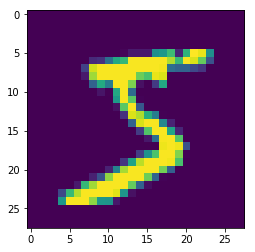

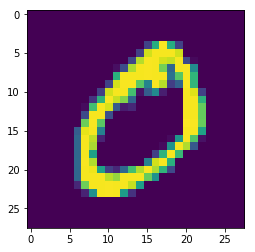

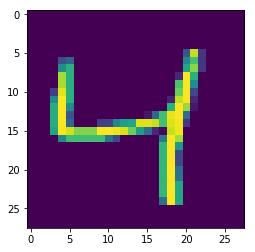

In [3]:
# Print the first three images in the training set
for i in range(3):
    plt.imshow(trainX[i])
    plt.show()

We have the number 5 as first image in the training set. We are sure that we have our data in tact.

It is always helpful when you are working with computer vision problem to plot the data before doing any algorithm work. It's a quick sanity check that can prevent easily avoidable mistakes such as misinterpreting the data dimensions.

## Preprocessing

Since that we have loaded the dataset lets have a look at the shape of the dataset that say how many images we have in our data.

In [4]:
# Shape of the Image feature/pixel value
print(trainX.shape)
print(testX.shape)

(60000, 28, 28)
(10000, 28, 28)


So it's appear that there are 60,000 sample of images in the training set and 10000 images on the test set. Each and every images are of size 28*28 pixels.

But we have a problem here. Having the images as array shape that representing the image pixel ie) (No of images, height, width) is not going to help us for the KNN alogithum feature representation. We need to reshape it in to the following format.

(No of images, width * height)

Lets do that.

In [5]:
# Reshaping the image feature
X_train = trainX.reshape(trainX.shape[0], trainX.shape[1] * trainX.shape[1])
X_test = testX.reshape(testX.shape[0], testX.shape[1] * testX.shape[1])

# Verifying the reshaping 
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


Thus we have reshaped the image properly. Just to be sure that we didn't loose any information while doing the reshaping. Let revert one of the image to old shape and try to print the image and see whether we are able to see it or not.

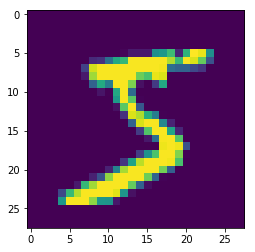

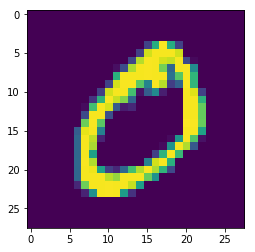

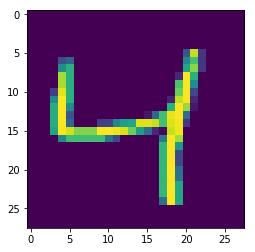

In [6]:
# Plot the first image in the train set
for i in range(3):
    plt.imshow(X_train[i].reshape(28, 28))
    plt.show()

Thus it proves that we have converted our X feature vectors of train and test properely.

Now that being done. Let us move our focus over to the labels for images which says what the number in the image is by checking the shape of the numpy array.

In [7]:
# Print the shape of the array that contains the image labels
print(trainY.shape)
print(testY.shape)

(60000,)
(10000,)


We will reshape the label arrays to shape (length of labels, 1) in order to have ease access while doing computation in the KNN algorithm.

In [8]:
# Reshape the label array
y_train = trainY.reshape(len(trainY), 1)
y_test = testY.reshape(len(testY), 1)

# Check the shape of reshaped label
print(y_train.shape)
print(y_test.shape)

(60000, 1)
(10000, 1)


And here we are reshaped our label perfectly as required. In order to handle the code neat and to provide reusablity fo the code, I have coded everything in a object oriendted class object. 

## Nearest Neighbor Class

I am writing up all my code as much as possible to be a object oreinted programming so that I won't be facing memeory management issuse.

Nearest Neighbor class as the name suggest is consists variable and fucntions that could efficiently handle the KNN algorithm problem. More details on each and everything is in the Doc String.

In [9]:
class KNearestNeighbor:
    """ Perform KNN classification on data
    
    Takes the feature vactor of the training set and map it in space
    along with their label. Using the testing set compute the distance from 
    all the points in the testing set to all the points in the training set.
    K minimum distance from the point by taking the maximum vote on the 
    labels is given as label to the test point as prediction.
    
    Arguments:
        k: No. of nearest points to consider while makeing prediction
        X: Training data
        y: Training data labels
        subset_cutoff: Minimum number of near by distance to keep in the 
            distance matrix
        dists = Sorted distance matrix of n near by points decided by subset_cutoff
        k_values: List of K values to use in the leave one out cross validation
        best_k: Best K value from the cross validation
        best_error: Best error value from the cross validation. Default is float("inf")
        parameter_list: List of dict of K and it is error values from the 
            cross validation
        binning: String. whether we are bining or averaging or summing or maxing 
            is represented
    """
    
    def __init__(self, k = 1, binning = "No", subset_cutoff = 25):
        self.k = k
        self.X = np.array([])
        self.y = np.array([])
        self.dists = np.array([]).reshape(0,0)
        self.k_values = []
        self.best_k = 0
        self.best_error = float("inf")
        self.parameter_list = []
        self.subset_cutoff = subset_cutoff
        self.binning = binning
    
    def get_variable_name(self, variable):
        """ Gives the variable name
        
        Argument:
            variable: Variable to get the name
            
        Returns: 
            String. Name of the variable
        """
        return [k for k,v in locals().items() if v is variable][0]
        
    def row_wise_norms(self, X, squared=False):
        """ Row-wise (squared) Euclidean norm of X.
        
        Equivalent to np.sqrt((X * X).sum(axis=1)), but also supports sparse
        matrices and does not create an X.shape-sized temporary.
        Performs no input validation.
        
        Argument:
            X: Data matrix to compute the row wise norm
            squared: Represents X matrix is already squared or not. Default is False
            
        Returns: 
            norms: Norms of the data row wise
        """
        # Check for the sparse in the matrix
        if issparse(X):
            # Check for the instance of the csr matrix
            # if not compute the csr matrix
            if not isinstance(X, csr_matrix):
                X = csr_matrix(X)
            # Compute the row wise norms
            norms = csr_row_norms(X)
        else:
            # Shorthand quick functioning of the matrix squared calc
            norms = np.einsum('ij,ij->i', X, X)
        # Checked for squared if it is compute the square 
        # root of the data matrix
        if not squared:
            np.sqrt(norms, norms)
        return norms
    
    def safe_dot_product(self, X, Y, dense_output=False):
        """ Dot product that handle the sparse matrix case correctly
        
        Uses BLAS GEMM as replacement for numpy.dot where possible
        to avoid unnecessary copies.
        
        Arguments:
            X : array or sparse matrix
            Y : array or sparse matrix
            dense_output : boolean, default False
                When False, either ``X`` or ``X`` being sparse will yield sparse
                output. When True, output will always be an array.
                
        Returns:
            dot_product : array or sparse matrix
                sparse if ``X`` or ``Y`` is sparse and ``dense_output=False``.
        """
        # Check for sparseness of the matrix
        if issparse(X) or issparse(X):
            # Compute the elementwise multiplication
            ret = X * Y
            # Check for the dense and toarray attribute if then change using toarray
            if dense_output and hasattr(ret, "toarray"):
                ret = ret.toarray()
            # Return the multiplied value
            return ret
        else:
            # Compute the dot product and return it
            return np.dot(X, Y)
    
    def euclidean_distances(self, X, Y):
        """ Euclidean distance between two matrix or vectors
        
        Euclidean distance is actually a two norm distance computed by
        taking the square root of squared difference between all those 
        points. Outputs a distance matrix
        
        Arguments:
            X: First matrix for which you want to compute the distance
            Y: Second matrix for which you want to compute the distance
            
        Returns:
            Distance Matrix between X and Y
        """
        # Check the X and Y arrays for pairwise relationship between them
        X, Y = check_pairwise_arrays(X, Y)
        # Compute the row wise norms
        XX = self.row_wise_norms(X, squared=True)[:, np.newaxis]
        # Shortcut in the common case euclidean_distances(X, X)
        if X is Y:  
            YY = XX.T
        else:
            YY = self.row_wise_norms(Y, squared=True)[np.newaxis, :]
        # Compute the distances
        distances = self.safe_dot_product(X, Y.T, dense_output=True)
        distances *= -2
        distances += XX
        distances += YY
        np.maximum(distances, 0, out=distances)
        # Check if X is same as y and vice versa
        if X is Y:
            # Ensure that distances between vectors and themselves are set to 0.0.
            # This may not be the case due to floating point rounding errors.
            distances.flat[::distances.shape[0] + 1] = 0.0
        # Compute the square root and return it
        return np.sqrt(distances, out=distances)

    def fit(self, X, y, cv_k = None, binning = "No"):
        """ Fit the KNN for the data
        
        Map the Train set with its label. Compute the best k and errors 
        using leave one out as the cross validation method. Distance matrix
        is computed once and save in the file and retrive from the file next
        time whenever required 
        
        Arguments:
            X: Feature vector for the KNN algorithm
            y: Labels of the data
            cv_k: Limit for the k value to be in Leave one out 
                cross validation. Default is None
            binning: Is the fit is for Binning or summing or averaging or
                max of the strides run over the matrix
                
        Returns:
            None
        """
        # Map the data values to the class object
        self.X = X
        self.y = y
        # Checking whether cross validation is opted for
        if cv_k is not None:
            # Store the Cross validation k values in the class object
            self.k_values = [k + 1 for k in range(cv_k)]
            if(self.dists.shape[0] != X.shape[0] or self.dists.shape[1] != X.shape[1]):
                self.binning = binning
                my_file = Path("distance_matrix/distance_sorted_deleted_" +\
                               str(X.shape[0]) + "_" + str(X.shape[1]) + "_" + self.binning + ".npy")
                if my_file.is_file():
                    self.dists = np.load(my_file)
                else:
                    # Compute the distance and save in the class object
                    self.dists = self.euclidean_distances(X, self.X)
                    # Sort and delete the dist between the same points
                    self.dists = np.argsort(self.dists)
                    self.dists = np.delete(self.dists, 0, 1)
                    # Save the sorted array to a file
                    np.save("distance_matrix/distance_sorted_deleted_" +\
                            str(X.shape[0]) + "_" + str(X.shape[1]) + "_" + self.binning + ".npy", self.dists)
            self.best_error = float("inf")
            self.parameter_list = []
            for k in self.k_values:
                # Compute the nearest labels
                nearest = self.y[self.dists[:, :k]].reshape(self.dists.shape[0], k)
                # Get the max vote
                prediction = mode(nearest, axis = 1)[0]
                error = 100 - self.accuracy(y, prediction)
                parameters = {'K': k, 'Error': error}
                self.parameter_list.append(parameters)
                # Update the error and K value 
                if error < self.best_error:
                    self.best_error = error
                    self.best_k = k 
        
    def predict_labels(self, k):
        """ Predict the label using distance matrix
        
        Distance matrix from the train time is used over the true label 
        to make the prediction by taking the maximum vote on the 'k' nearest
        points. 
        
        Arguments:
            k: No. of nearest points to consider while makeing prediction
            
        Returns:
            Labels for the prediction
        """
        # Get the number of images in the test set
        num_test = self.dists.shape[0]
        # Compute the nearest labels
        nearest = self.y[self.dists[:, :k]].reshape(num_test, k)
        # Get the max vote
        label = mode(nearest, axis = 1)[0]
        return label
    
    
    def predict(self, X, k = None, binning = "No"):
        """ Predict the label for the input feature
        
        Takes the input matrix and computes the distance matrix with the train
        feature. Distance matrix is computed once and save in the file and
        retrive from the file next time whenever required
        
        Arguments:
            k: No. of nearest points to consider while makeing prediction
            binning: Is the fit is for Binning or summing or averaging or
                max of the strides run over the matrix
                
        Returns:
            Prediction for the input matrix X 
        """
        # Check whether k is not none in the funtion argument
        # Store the k value in the class object
        if k is not None:
            self.k = k
        # Check dists object already avaliable in the class object
        if(self.dists.shape[0] != X.shape[0] or self.dists.shape[1] != X.shape[1]):
            self.binning = binning
            my_file = Path("distance_matrix/distance_sorted_testset_" +\
                           str(X.shape[0]) + "_" + str(X.shape[1]) + "_" + self.binning + ".npy")
            if my_file.is_file():
                self.dists = np.load(my_file)
            else:
                # Compute the distance and save in the class object
                self.dists = self.euclidean_distances(X, self.X)
                # Sort distance matrix
                self.dists = np.argsort(self.dists)[:, :25]
                # Save the sorted array to a file
                np.save("distance_matrix/distance_sorted_testset_" +\
                        str(X.shape[0]) + "_" + str(X.shape[1]) + "_" + self.binning + ".npy", self.dists)
        # Call the predict_labels() to get the labels
        prediction = self.predict_labels(k = self.k)
        return prediction
    
    def confusion_matrix_plot(self, actual, pred, title = "Confusion Matrix", height = 9, width = 12):
        """ Heatmap used to represent Confusion Matrix
        
        Takes actual and predicted value of the KNN algorithm to plot
        the Confusion matrix in the form heatmap using bokeh
        
        Arguments:
            actual: Original labels
            pred: Predicted labels
            title: Title for the plot
            height: Height for the plot
            width: Width for the plot
        
        Returns:
            None
        """
        # Get the confusion matrix
        conf_mat = confusion_matrix(actual, pred)
        # Frame the pandas dataframe
        df = pd.DataFrame(conf_mat, index = [i for i in np.unique(actual)], columns = [i for i in np.unique(actual)])
        # Create the heatmap
        plt.figure(figsize = (width, height))
        ax = sns.heatmap(df, annot=True, annot_kws={"size": 18}, fmt = "d", cmap = sns.cubehelix_palette())
        # Customize the style of the heatmap
        # Set the title, it's font size and position
        ax.axes.set_title(title, fontsize = 30)
        ax.title.set_position([.5, 1.03])
        # Set X and Y labels and it font size
        ax.set_xlabel("Predicted", fontsize = 25)
        ax.set_ylabel("Actual", fontsize = 25)
        # Set the X and Y tick labels and font size
        ax.set_xticklabels(labels = [i for i in np.unique(y_test)], fontsize = 15)
        ax.set_yticklabels(labels = [i for i in np.unique(y_test)], fontsize = 15)
        # Show the plot
        plt.show()
        
    def accuracy(self, actual, pred, normalize = False):
        """ Compute the model accuracy
        
        Check for the normalization on the predicted value and 
        compute the model accuracy accordingly
        
        Arguments:
            actual: Original labels
            pred: Predicted labels
            normalize: Default is False. Whether the pred argument is 
                normalized or not
                
        Returns:
            acc: accuracy percentage of the model rounded of to 4 decimal
                points
        """
        # Intialize the accuracy
        acc = 0.
        # Normality check and finding the accuracy
        if normalize == True:
            acc = accuracy_score(actual, pred, normalize)
        else:
            acc = accuracy_score(actual, pred)
        return round(acc, 6) * 100
    
    def testing_error(self, actual, pred):
        """ Testing Error for each labels
        
        Compute the testing error (also accuracy) for each and every 
        labels in the testing set
        
        Arguments:
            actual: Original labels
            pred: Predicted labels
            
        Returns:
            result_df: Dataframe of labels and its acuracy and error
        """
        error_list = []
        labels = list(np.unique(actual))
        for i in labels:
            index, _ = np.where(actual == i)
            correct = (actual[index] == pred[index]).reshape(len(index), )
            error = round((1 - (np.sum(correct) / len(index))) * 100, 4)
            error_list.append(error)
        result_df = pd.DataFrame({"Label": labels, "Error (%)": error_list, 
                                  "Accuracy (%)": [(100 - error) for error in error_list]})
        return result_df

## Feature Transformation Class

THe feature transformation class is combination of varaible and functions that can be used to transform the feature using strides over the images and binning the each strides with summing, averaging, max , min pooliong over the images.

In [10]:
class FeatureTransformation:
    """ Transforms the features 
    
    Feature of the data is transformed by mainly taking the strides of n
    and computing the summing, averaging, max pooling, min pooling of 
    the features. Basicaly it is the downsample of the whole data
    
    Arguments:
        None
    """
    
    def __init__(self):
        pass
    
    def strided_rescale(self, g, bin_fac, binning):
        """ Rescale the data with strides and type of binning
        
        Takes the run over the image data using strides of n and 
        shrinks each strides depending on the binning method passed.
        
        Arguments:
            g: Data of the image in the feature vectors
            bin_fac: Represent the strides to consider(strides * strides)
            binning: Type of binning to apply {sum, max, min, others will 
                compute average of strides}
            
        Returns:
            Shrinked image of feature vector
        """
        # Get the strides of the whole image
        strided = np.lib.stride_tricks.as_strided(g,
            shape=(g.shape[0]//bin_fac, g.shape[1]//bin_fac, bin_fac, bin_fac),
            strides=((g.strides[0]*bin_fac, g.strides[1]*bin_fac)+g.strides))
        # Check the binning method and compute thte stride accordingly
        if binning is "sum":
            return strided.sum(axis=-1).sum(axis=-1)
        elif binning is "max":
            return strided.max(axis=-1).max(axis=-1)
        elif binning is "min":
            return strided.min(axis=-1).max(axis=-1)
        else:
            return strided.mean(axis=-1).mean(axis=-1)
    
    def down_sample(self, data, n, binning = None):
        """ Downsample the data by n
        
        Computes the nthe feature downsample or downsamples by using 
        techniques such as summing, binning, max pooling, min pooling 
        and average
        
        Arguments:
            data: Data of the image in the feature vectors
            n: Represent the strides to consider(strides * strides)
            binning: Type of binning to apply
            
        Returns:
            Downsampled/Shrinked image of feature vector
        """
        # Check for binning downsample the image if the binning is none
        # else do smart downsampling by passing it to the strides()
        if binning is None:
            # get the index
            index = [i-1 for i in np.arange(n, data.shape[1] + 1, n)]
            # Downsample the image
            down_sampled = np.array([data[:, i] for i in index])
            return down_sampled.T
        else:
            # Get the new image side
            new_side = int(data.shape[1] / n)
            # Intiualize the strides for storing the results
            strided = np.zeros((data.shape[0], new_side, new_side))
            # Compute the strides and store the values
            for i in range(data.shape[0]):
                strided[i] = self.strided_rescale(data[i], n, binning)
            return strided

As we have our core classes defined let start answering the questions.

## Question 1

(10 pts) Implement a 1-nearest neighbor classifier that considers the image pixels to be one long feature vector. The vector will be 28*28 = 784-dimensions long (one feature for each pixel in the image). Do not do any scaling or normalization on the pixel values. Present the testing error for each digit in a table.

We will use Nearest Neighbor class objects to solve this question. First we will create the object or instance of the class and fit the train data using the fit().

In [11]:
# Nearest Neighbor object creation
knn = KNearestNeighbor()

# Fit the model
knn.fit(X_train, y_train)

### Predict on the test set

As we have the class object and fitted our model. Lets try to predict the images in the testing set using predict() in KNearestNeighbor class and passing K = 1. We will try to record the time it took to predict the test set also.

In [12]:
# Store the starting time for query time computation
start_time = timeit.default_timer()

# Make prediction on the test set
pred1 = knn.predict(X_test, k = 1)

# Print the Query time
print("Query time:", round(timeit.default_timer() - start_time, 4), "Seconds")

Query time: 3.2365 Seconds


Query time for this function call to make the prediction was almost ~1 min on average before. But by using the techinique of storing the sorted distance matrix and retriving it from the next time after it creation has reduced the computation time of this code chunk largely. The computation time is just ~4 seconds. This is amazing.

### Accuracy and error rate

Though we have predicted the test set. We need to know how good is the model by measuring some metrics. I am going to find the accuracy and error rate of the model to see how well it have performed.

In [14]:
# Call the accuracy to get the accuracy
acc = knn.accuracy(y_test, pred1)
# Calculate the error from accuracy
err = 100 - acc
# Print both accuracy and error
print("The accuracy rate of the model is", acc, "percentage.")
print("The error rate of the model is", err, "percentage.")

The accuracy rate of the model is 96.91 percentage.
The error rate of the model is 3.09 percentage.


With the accuracy of 96.91(almost 97) percentage, KNN with K = 1 looks like a good model overall. But we cannot confirm on that yet, as there are ways that we can use to improvise the model performance that we might be seeing in the latter questions.

### Confusion Matrix

Confusion Matrix help us understand the model performance by provinding insights on how well the model performed on each digits, and where it is strugling to make the prediction.

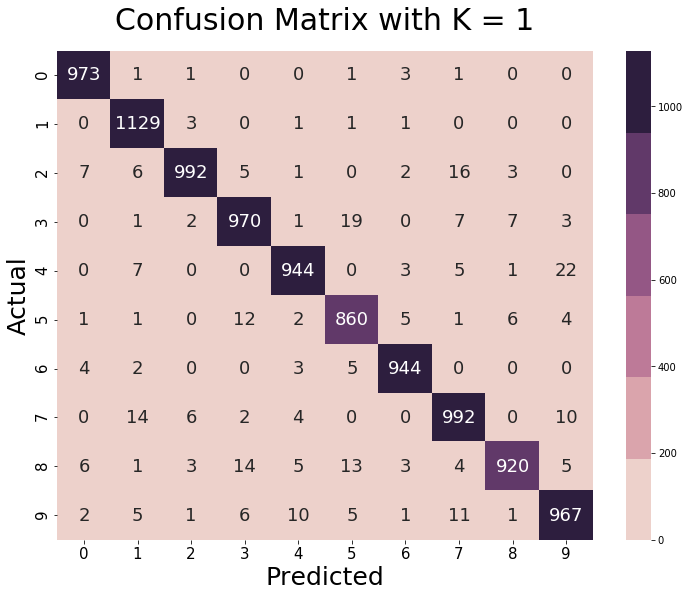

In [15]:
# Create and show the Confusion matrix plot
knn.confusion_matrix_plot(y_test, pred1, "Confusion Matrix with K = 1")

From the confusion matrix, I was able to infer lot of insights which are as follows.

- The darker diagonals on the confusion matrix indicates we have good model that was able to predict the digits properly
- It looks like approximately digits 1 has more likely chances to be right. However this can be clearly stated once we get to our testing error table.
- Model is failing with the images of 4 where it confusion it to be 9 which is pretty much understandable because of the way 4 and 9 is written.
- In addition, we have 2 which are identified as 7 and 7 idneitfied as 1. Also 8 as 3.

Overall the missclassification that have happened kind of make sense looking at the digits and its writing structure. Lets also see the testing error table for each digits.

### Testing error on each digit

Now lets see the testing error on each digits and see whether there is something interesting out there for us.

In [16]:
# Computing the testing error for each digits
result_KNN = knn.testing_error(y_test, pred1)
# Printing the testing error table
result_KNN

,Accuracy (%),Error (%),Label
0,99.2857,0.7143,0
1,99.4714,0.5286,1
2,96.1240,3.8760,2
3,96.0396,3.9604,3
4,96.1303,3.8697,4
5,96.4126,3.5874,5
6,98.5386,1.4614,6
7,96.4981,3.5019,7
8,94.4559,5.5441,8
9,95.8375,4.1625,9


In [17]:
# Custom style attribute function
# Best practive for bokeh users
def custom_analysis_line_plot(data, x_col, y_col, title, width = 800, height = 600, xlab = "X-axis", ylab = "Y-axis", 
                         line_width = 4):
    # Creating the variables for the color prop
    color = d3['Category20b'][17][2]
    # Create the figure object
    p = figure(width = width, height = height, title = title, x_axis_label = xlab, y_axis_label = ylab)
    # Provide the attribute for the line()
    p.line(data.iloc[:, x_col], data.iloc[:, y_col], color = color, line_width = line_width)
    # Add plot style attributes
    p.title.text_font_size = "20pt"
    p.title.align = "center"
    p.xaxis.axis_label_text_font_size = "20pt"
    p.yaxis.axis_label_text_font_size = "20pt"
    return show(p)

In [18]:
# Show the plot
custom_analysis_line_plot(data = result_KNN, x_col = 2, y_col = 0, title = "K vs Error %", 
                     width = 800, height = 600, xlab = "Labels/Digits", ylab = "Testing Error (%)", line_width = 4)

Above we have the table that shows testing error and also accuracy rate for each digit on the test set. From this we infer that the 

- The model performs best for images of digit 1 with 0.5286 error rate on the test set
- The model performs is less on images digit 8 with 5.5441 error rate on the test set
- Images of digits 0, 1, 6 looks to have better chances of getting identified correctly compared to other digits

Overall, still there is some error rate on some digits, combined accuracy of 96.91 percent is significantly considered to be high in the Machine Learning community. However using this model in real world application depends completely on the problem we would like to solve.

### Sanity check for this Question

Let us just check our model created by double checking using the sklearn's KNN module.

In [146]:
# Sanity check for KNN with K = 1 using SKlearn
neigh = KNeighborsClassifier(n_neighbors = 1)
neigh.fit(X_train, y_train)
prediction = neigh.predict(X_test)
print("The accuracy from sklearn is", round(accuracy_score(y_test, prediction), 4) * 100, "percentage")

The accuracy from sklearn is 96.91 percentage


Thus sklearn results is same as that of my model which is 96.91 shows that my algorithm is working fine.

## Question 2

(10 pts) Implement a KNN leave-one-out approach and test values of K from 1 to 20. Plot the leave-one-out error vs. K. Present the testing error for best value of K for each digit in a table. (If you are running into time problems using all 60,000 data points for leave-one-out, feel free to randomly sample the training set to estimate the best K.)

In [19]:
# Store the starting time for query time computation
start_time = timeit.default_timer()

# Create class object and fir the model with Leave one out
# cross validation for k from 1 to 20
knn = KNearestNeighbor()
knn.fit(X_train, y_train, cv_k = 20)

# Print the Query time
print("Query time:", round(timeit.default_timer() - start_time, 4), "second(s)")

Query time: 51.5236 second(s)


Apparently the computation for creating the whole distance matrix and then finding the K nearest neighbour for 20 k's caused about 28 mins. However, I have saved the sorted version of the whole big distance matrix into a numpy formatted file so that when ever if the values are required it can be returned from the file and computation time can be hugely reduced. 

By following the above approach I have reduced the execution time from 28 mins to ~50 seconds. Here the distance matrix is loaded from the file. However if the distance matrix is already in the class object instance then it will be super fast with a query time ~0.7 seconds. With that being done we have our best k value and errors from the 20 iteration we did above. Lets look at that first.

### Choosing the best K

In my code above in the fit function I have already computed the best k value and its error. However, in order to understand things intutively, lets plot the k vs error rate.

In [20]:
# Show the plot
parameter_list_df = pd.DataFrame(knn.parameter_list)
custom_analysis_line_plot(data = parameter_list_df, x_col = 1, y_col = 0, title = "K vs Error %", 
                     width = 800, height = 600, xlab = "No. Neighbors (K)", ylab = "Error (%)", line_width = 4)

From the graph it is evident and clear that we have very low error rate for K = 3 which is 2.6033. Let just confirm the number by looking at the best k value and its error rate from the corresponding variable in the class object.

In [21]:
print("The best K value for this dataset according to leave one out cross validation is", knn.best_k,
     "and the correponding error rate is", knn.best_error)

The best K value for this dataset according to leave one out cross validation is 3 and the correponding error rate is 2.6033


Thus above we can see that my inference from the graph is true. The best K value is 3. Lets use the best K value which is 3 to predict theimages in the test set.

### Predicting on test set with K = 3

As we have the class object and fitted our model with leave one cross validation, we have figured out that K = 3 will be the best model to use to make the prediction on new images. Lets try to predict the images in the testing set using predict() in KNearestNeighbor class with K as 3. 

In [22]:
# Store the starting time for query time computation
start_time = timeit.default_timer()
# Make prediction on the test set
pred2 = knn.predict(X_test, k = knn.best_k)
# Print the Query time
print("Query time:", round(timeit.default_timer() - start_time, 4), "Seconds")

Query time: 7.7043 Seconds


Thus we have made our prediction on the test set with k = 3. When looking at the Query time, it took ~7 seconds to do the computation if it has to load the distance matrix from the file. If the distance matirx is not found, for the first time it will take ~5 mins to compute. 

If we already have the correct distance matrix in the class object then computation time will be ~40 miliseconds which is super fast. 

We just load this matrix from the file and use those as a look up tables and make our prediction. That is the reason we have small prediction time here which is good.

### Accuracy and error rate

Though we have predicted the test set. We need to know how good is the model by measuring some metrics. I am going to find the accuracy and error rate of the model to see how well it have performed on the test set.

In [23]:
# Call the accuracy to get the accuracy
acc = knn.accuracy(y_test, pred2)
# Calculate the error from accuracy
err = 100 - acc
# Print both accuracy and error
print("The accuracy rate of the model is", acc, "percentage.")
print("The error rate of the model is", err, "percentage.")

The accuracy rate of the model is 97.05 percentage.
The error rate of the model is 2.95 percentage.


The KNN model has the accuracy of 97.05% with K = 3 which is slightly better then the model with K = 2 which has accuracy of 96.91. Looking at the computation time for the test set prediction, K = 1 cost ~6 seconds where as K = 3 cost ~8. Thus choosing which model to use in real time depends on the bussiness problem and the time vs acccuracy trade off.

### Confusion Matrix

Confusion Matrix help us understand the model performance by provinding insights on how well the model performed on each digits, and where it is strugling to make the prediction. Let see how our KNN model with K = 3 has performed.

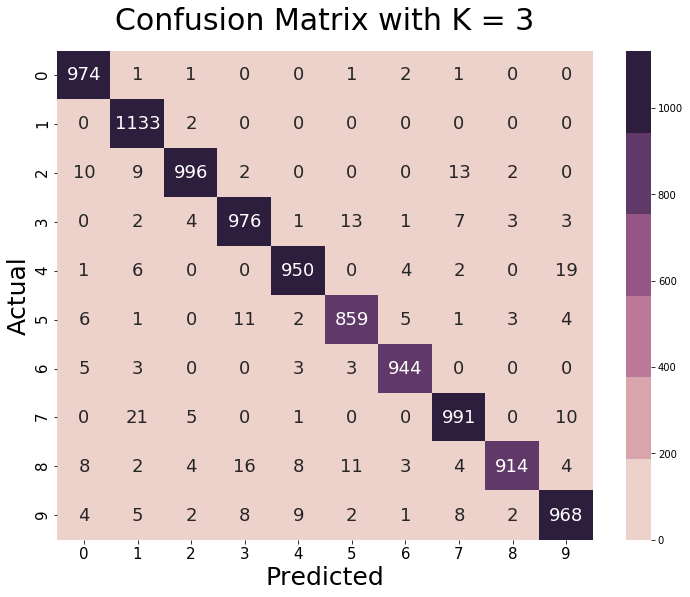

In [24]:
# Create and show the Confusion matrix plot
knn.confusion_matrix_plot(y_test, pred2, "Confusion Matrix with K = 3")

The Confusion Matrix is almost similar to Confusion Matrix which I got before for K = 1. The reasons is so obvious that with small increase in the accuracy of 96.91 to 97.05 % by using K = 3.From the confusion matrix, I was able to infer lot of insights which are as follows.

- More darke the diagonal background, large the number of correctly identified images on the test set prediction. 
- Thus model is performing good overall.
- It looks like approximately digits 1 has more likely chances to be right. However this can be clearly stated once we get to our testing error table.
- Model is failing with the images of 4 where it confusion it to be 9 which is pretty much understandable because of the way 4 and 9 is written.
- In addition, we have 2 which are identified as 7 and 7 idneitfied as 1. Also 8 as 3.

Though some of inference is similar to K = 1, there is siight increase in the numbers on the diagonals on comaparison which is evident for the improvement in the model.

### Testing error on each digit

Now lets see the testing error on each digits for this model and see whether there is something interesting out there for us.

In [25]:
# Computing the testing error for each digits
result_KNNCV = knn.testing_error(y_test, pred2)
# Printing the testing error table
result_KNNCV

,Accuracy (%),Error (%),Label
0,99.3878,0.6122,0
1,99.8238,0.1762,1
2,96.5116,3.4884,2
3,96.6337,3.3663,3
4,96.7413,3.2587,4
5,96.3004,3.6996,5
6,98.5386,1.4614,6
7,96.4008,3.5992,7
8,93.8398,6.1602,8
9,95.9366,4.0634,9


Above we have the table that shows testing error and also accuracy rate for each digit on the test set for the KNN model with K = 3. From this we infer that the 

- The model performs best for images of digit 1 with 0.1762 error rate on the test set
- The model performs is less on images digit 8 with 6.1602 error rate on the test set
- Images of digits 0, 1, 6 looks to have better chances of getting identified correctly compared to other digits

But how this testing error for K = 3 compared to the first model with K = 1? Can we answer that?

### Testing Error Comparison between K = 1 and K = 3

I thought it will be good to identify is there any relationship between this model and previous model. Better way to handle this problem is using visualization. 

In [26]:
# Custom style attribute function
# Best practive for bokeh users
def custom_analysis_multiline_plot(data, title, width = 800, height = 600, xlab = "X-axis", ylab = "Y-axis", 
                         line_width = 4):
    stop = 3 + (data.shape[1] - 1) * 4
    colour_range = [i  for i in range(2, stop, 4)]
    # Creating the variables for the color prop
    colors_list = [d3['Category20b'][17][i] for i in colour_range]
    ys = [data.iloc[:, i] for i in range(data.shape[1])]
    col_names = data.columns
    # Create the figure object
    p = figure(width = width, height = height, title = title, x_axis_label = xlab, y_axis_label = ylab)
    # Iterate through each degree and draw the lines
    for (col_name, colr, y) in zip(col_names, colors_list, ys):
        current_plot = p.line(y.index, y, color = colr, legend = col_name.upper(), line_width = line_width)
        p.legend.location = "top_left"
    # Add plot style attributes
    p.title.text_font_size = "20pt"
    p.title.align = "center"
    p.xaxis.axis_label_text_font_size = "20pt"
    p.yaxis.axis_label_text_font_size = "20pt"
    return show(p)

In [27]:
# Creating the dataframe from the testing errors
plot_df = pd.DataFrame({'K = 1': result_KNN['Error (%)'], 'K = 3': result_KNNCV['Error (%)']})
# Calling the custom line plot function
custom_analysis_multiline_plot(data = plot_df, title = "Models vs Testing Error on each digits",
                          width = 800, height = 600, xlab = "Image Label (digit)", ylab = "Testing Error (%)",
                          line_width = 4)

From the above graph we can see that the error % for K = 3 is small for images of digits 0 to 4. But for the images of 5 and 8 its higher than the testing error from model with K = 1. In fact K = 3 has highest error for digit 6 over all the testing error on each digits from both the K = 1 and 3 model.

## Question 3

(20 pts) Implement a function that downsamples the image by a factor of n. For example, if n is 4 then you will sample every 4th pixel (feature) in the 784-dimension feature vector. Repeat the KNN leave-one-out experiment with at least 4 different values of n. Comment on the testing results and the query time of the classifier.

For this question, I am going to apply downsamples for n = 4, 8, 16, 32 as four different values on the 784 dimension feature vector.

- n = 4
- n = 8
- n = 16
- n = 32

Let just get started by fitting the model with leave one out and find out which k suits for which nth downsample feature vectors.

### Fitting and selecting the best K

Since the computation time is huge, I am running each downsample in a seperate section

In [28]:
# Creating the Feature Transformation class object
transformation = FeatureTransformation()
# Create KNearestNieghbor Class
knn = KNearestNeighbor()

In [29]:
###########     N = 4    ###########
# Store the starting time for query time computation
start_time = timeit.default_timer()

# Fit the model with Leave one out cross validation for k from 1 to 20
X_train_ds = transformation.down_sample(X_train, 4)
knn.fit(X_train_ds, y_train, cv_k = 20)

# Print the Query time
time1 = round(timeit.default_timer() - start_time, 4)
print("Query time for N = 4:", time1, "second(s)")

# Get the needed terms in this stage
parameter_list_ds4 = knn.parameter_list
best_k_ds4 = knn.best_k
best_error_ds4 = knn.best_error


###########     N = 8    ###########
# Store the starting time for query time computation
start_time = timeit.default_timer()

# Fit the model with Leave one out cross validation for k from 1 to 20
X_train_ds = transformation.down_sample(X_train, 8)
knn.fit(X_train_ds, y_train, cv_k = 20)

# Print the Query time
time2 = round(timeit.default_timer() - start_time, 4)
print("Query time for N = 8:", time2, "second(s)")

# Get the needed terms in this stage
parameter_list_ds8 = knn.parameter_list
best_k_ds8 = knn.best_k
best_error_ds8 = knn.best_error


###########     N = 16    ###########
# Store the starting time for query time computation
start_time = timeit.default_timer()

# Fit the model with Leave one out cross validation for k from 1 to 20
X_train_ds = transformation.down_sample(X_train, 16)
knn.fit(X_train_ds, y_train, cv_k = 20)

# Print the Query time
time3 = round(timeit.default_timer() - start_time, 4)
print("Query time for N = 16:", time3, "second(s)")

# Get the needed terms in this stage
parameter_list_ds16 = knn.parameter_list
best_k_ds16 = knn.best_k
best_error_ds16 = knn.best_error


###########     N = 32    ###########
# Store the starting time for query time computation
start_time = timeit.default_timer()

# Fit the model with Leave one out cross validation for k from 1 to 20
X_train_ds = transformation.down_sample(X_train, 32)
knn.fit(X_train_ds, y_train, cv_k = 20)

# Print the Query time
time4 = round(timeit.default_timer() - start_time, 4)
print("Query time for N = 32:", time4, "second(s)")

# Get the needed terms in this stage
parameter_list_ds32 = knn.parameter_list
best_k_ds32 = knn.best_k
best_error_ds32 = knn.best_error

Query time for N = 4: 51.4745 second(s)
Query time for N = 8: 57.9078 second(s)
Query time for N = 16: 57.271 second(s)
Query time for N = 32: 57.1625 second(s)


Above we have the computation time for each N values which is almost same for all the N values. The computation time is ~1 min as I am retriving the distance matrix from the file. It took ~23 mins of computation time for computing the distance matrix first time if the file is not in your system. When ever it is needed, the corresponding file will get loaded as directed by my implementation. One thing to note here is that my implementation took almost the same time to do Leave one out for all the four different N values. This is because I am computing the 60000 * 60000 matrix irrespective of what the N value is.

### Choosing the best K

As we have our leave one out fit run for all 4 different down samples, lets do some analysis on the diffrent error values with respect to each K for those 4 downsample methods. We will use visualization to get this analysis going.

In [30]:
# Custom style attribute function
# Best practive for bokeh users
def custom_error_NK_plot(data, title, colour_range, width = 800, height = 600, xlab = "X-axis", ylab = "Y-axis", 
                         line_width = 4, legend_location = "top_right"):
    # Creating the variables for the color prop
    colors_list = [d3['Category20b'][17][i] for i in colour_range]
    # Structuring xs and ys
    xs = [data.index + 1] * len(colour_range)
    ys = [data.iloc[:, i] for i in range(data.shape[1])]
    col_names = data.columns
    # Create the figure object
    p = figure(width = width, height = height, title = title, x_axis_label = xlab, y_axis_label = ylab)
    # Iterate through each degree and draw the lines
    for (col_name, colr, x, y) in zip(col_names, colors_list, xs, ys):
        current_plot = p.line(x, y, color = colr, legend = col_name.upper(), line_width = line_width)
        p.legend.location = legend_location
    # Add plot style attributes
    p.title.text_font_size = "20pt"
    p.title.align = "center"
    p.xaxis.axis_label_text_font_size = "20pt"
    p.yaxis.axis_label_text_font_size = "20pt"
    return show(p)

In [31]:
# Creating the dataframe for the Leave one out CV for each N different downsamples
errors_NK_df = pd.DataFrame({'K': [d['K'] for d in parameter_list_ds4],
             'N = 4': [d['Error'] for d in parameter_list_ds4], 
             'N = 8': [d['Error'] for d in parameter_list_ds8], 
             'N = 16':[d['Error'] for d in parameter_list_ds16], 
             'N = 32': [d['Error'] for d in parameter_list_ds32]})

# Calling the custom line plot function
custom_error_NK_plot(data = errors_NK_df.iloc[:, 1:], title = "K vs Error for different downsamples",
                          width = 800, height = 600, xlab = "No. of Neighbors (K)", ylab = "Error (%)",
                          line_width = 4, colour_range = [2, 4, 6, 10], legend_location = "center")

From the graph we can see that the N = 4 with 5 Neighbors (K = 5) is having the lowest error percentage overall. We can also see that the trend between different downsamples is almost the same from the graph. And also it is so clear that Error increases as we increase N value for our downsample.

Below we have best error and most importantly best K value for each of the downsample fit we did.

| Downsample N | Best Error |  Best K  |
|--------------|------------|----------|
|   4   |  6.39      | <strong>5</strong> |
|   8   |  7.3533   |  <strong>5</strong> |
|   16  |  17.66   |  <strong>13</strong> |
|   32  |  39.8717   |  <strong>18</strong> |

### Prediction on the test set

With the process of choosing our best model, we have got to know what are the best K values that work for each downsample feature which we have applied over. Thus lets use those best k values from the leave one out cross validation fit and apply on the test set to make the prediction.

In [32]:
###########     N = 4    ###########
# Store the starting time for query time computation
start_time = timeit.default_timer()

# Make the transformation
knn.X = transformation.down_sample(X_train, 4)
X_test_ds = transformation.down_sample(X_test, 4)

# Make prediction on the test set
pred_ds4 = knn.predict(X_test_ds, k = best_k_ds4)

# Print the Query time
time1 = round(timeit.default_timer() - start_time, 4)
print("Query time for N = 4:", time1, "second(s)")


###########     N = 8    ###########
# Store the starting time for query time computation
start_time = timeit.default_timer()

# Make the transformation
knn.X = transformation.down_sample(X_train, 8)
X_test_ds = transformation.down_sample(X_test, 8)

# Make prediction on the test set
pred_ds8 = knn.predict(X_test_ds, k = best_k_ds8)

# Print the Query time
time2 = round(timeit.default_timer() - start_time, 4)
print("Query time for N = 8:", time2, "second(s)")


###########     N = 16    ###########
# Store the starting time for query time computation
start_time = timeit.default_timer()

# Make the transformation
knn.X = transformation.down_sample(X_train, 16)
X_test_ds = transformation.down_sample(X_test, 16)

# Make prediction on the test set
pred_ds16 = knn.predict(X_test_ds, k = best_k_ds16)

# Print the Query time
time3 = round(timeit.default_timer() - start_time, 4)
print("Query time for N = 16:", time3, "second(s)")


###########     N = 32    ###########
# Store the starting time for query time computation
start_time = timeit.default_timer()

# Make the transformation
knn.X = transformation.down_sample(X_train, 32)
X_test_ds = transformation.down_sample(X_test, 32)

# Make prediction on the test set
pred_ds32 = knn.predict(X_test_ds, k = best_k_ds32)

# Print the Query time
time4 = round(timeit.default_timer() - start_time, 4)
print("Query time for N = 32:", time4, "second(s)")

Query time for N = 4: 8.9822 second(s)
Query time for N = 8: 4.9349 second(s)
Query time for N = 16: 5.9828 second(s)
Query time for N = 32: 4.6764 second(s)


So we have made the prediction on the test set for each of the downsamples. Looking at the query time it is too small. Almost all of the prediction took around ~5 seconds. This is because of the similarity matrix computation which is already being done at first time execution. This similarity matrix of size 10000 * 10000 computation took about ~60 seconds for all the 4 different downsamples. We just load this matrix from the file and use those as a look up tables and make our prediction. That is the reason we have small prediction time here which is good. 

Moving further are their any trend prevaling with the time.

### Prediction Query time plot for N downsamples

In [33]:
# Show the plot
time = pd.DataFrame({'Downsamples N': [4, 8, 16, 32], 
                     'Query Time': [time1, time2, time3, time4]})
custom_analysis_line_plot(data = time, x_col = 0, y_col = 1, title = "Downsamples (N) Vs Query Time", 
                     width = 800, height = 600, xlab = "Downsamples", ylab = "Query Time", line_width = 4)

Most of the time when I was seeing the output it was around 5 seconds for all the models to make predictions. One thing to notice is that the ups and downs that have shown in the graph prevails irrespective of their scale.

### Accuracy and Error percentage

Though we have predicted the test set. We need to know how good is the model by measuring some metrics. I am going to find the accuracy and error rate of each models to see how well it have performed on the test set.

In [34]:
# Creating the error list to make plot
error_list = []
###########     N = 4    ###########
# Call the accuracy to get the accuracy
acc = knn.accuracy(y_test, pred_ds4)
# Calculate the error from accuracy
err = 100 - acc
# Add to the error list
error_list.append(err)
# Print both accuracy and error
print("N = 4")
print("The accuracy rate of the model is", acc, "percentage.")
print("The error rate of the model is", err, "percentage.")
print("\n")


###########     N = 8    ###########
# Call the accuracy to get the accuracy
acc = knn.accuracy(y_test, pred_ds8)
# Calculate the error from accuracy
err = 100 - acc
# Add to the error list
error_list.append(err)
# Print both accuracy and error
print("N = 8")
print("The accuracy rate of the model is", acc, "percentage.")
print("The error rate of the model is", err, "percentage.")
print("\n")


###########     N = 16    ###########
# Call the accuracy to get the accuracy
acc = knn.accuracy(y_test, pred_ds16)
# Calculate the error from accuracy
err = 100 - acc
# Add to the error list
error_list.append(err)
# Print both accuracy and error
print("N = 16")
print("The accuracy rate of the model is", acc, "percentage.")
print("The error rate of the model is", err, "percentage.")
print("\n")


###########     N = 32    ###########
# Call the accuracy to get the accuracy
acc = knn.accuracy(y_test, pred_ds32)
# Calculate the error from accuracy
err = 100 - acc
# Add to the error list
error_list.append(err)
# Print both accuracy and error
print("N = 32")
print("The accuracy rate of the model is", acc, "percentage.")
print("The error rate of the model is", err, "percentage.")
print("\n")

N = 4
The accuracy rate of the model is 93.23 percentage.
The error rate of the model is 6.77 percentage.


N = 8
The accuracy rate of the model is 92.49 percentage.
The error rate of the model is 7.51 percentage.


N = 16
The accuracy rate of the model is 82.41 percentage.
The error rate of the model is 17.59 percentage.


N = 32
The accuracy rate of the model is 60.2 percentage.
The error rate of the model is 39.8 percentage.




In [35]:
# Custom style attribute function
# Best practive for bokeh users
def custom_analysis_line_plot(data, x_col, y_col, title, width = 800, height = 600, xlab = "X-axis", ylab = "Y-axis", 
                         line_width = 4):
    # Creating the variables for the color prop
    color = d3['Category20b'][17][2]
    # Create the figure object
    p = figure(width = width, height = height, title = title, x_axis_label = xlab, y_axis_label = ylab)
    # Provide the attribute for the line()
    p.line(data.iloc[:, x_col], data.iloc[:, y_col], color = color, line_width = line_width)
    # Add plot style attributes
    p.title.text_font_size = "20pt"
    p.title.align = "center"
    p.xaxis.axis_label_text_font_size = "20pt"
    p.yaxis.axis_label_text_font_size = "20pt"
    return show(p)

In [36]:
# Create the dataframe
error_rate_df = pd.DataFrame({'Downsamples N': [4, 8, 16, 32], 
                             'Error': error_list})

# Show the plot
custom_analysis_line_plot(data = error_rate_df, x_col = 0, y_col = 1, title = "Downsamples (N) vs Error %", 
                     width = 800, height = 600, xlab = "Downsamples (N)", ylab = "Testing Error (%)", line_width = 4)

From the above printed result and also from the visualization we can clearly see that the error rate increases as increase our N in the downsamples selection. This is because big the N value less the number of features you are going to have for your model which makes sense.

### Confusion matrix

Confusion Matrix help us understand the model performance by provinding insights on how well the model performed on each digits, and where it is strugling to make the prediction. Let see how our four different KNN model with their each best K value has performed.

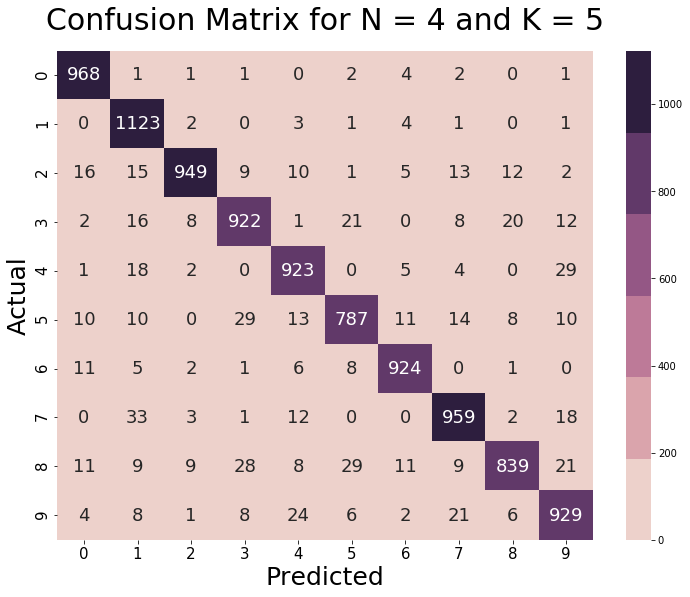

In [37]:
# Create and show the Confusion matrix plot
###########     N = 4    ###########
knn.confusion_matrix_plot(y_test, pred_ds4, "Confusion Matrix for N = 4 and K = " + str(best_k_ds4))

The above confusion matrix is showing the same insights as we saw in the previous two questions. In addition, we can see that the drop in accuracy for N = 4 is due to images of 3, 4, 5, 6, 8, 9 not getting identified as good as it does with all the features.

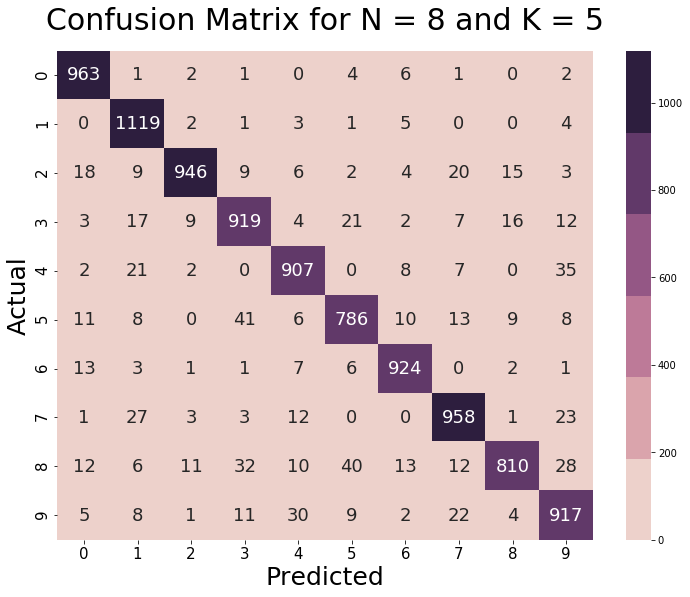

In [38]:
###########     N = 8    ###########
knn.confusion_matrix_plot(y_test, pred_ds8, "Confusion Matrix for N = 8 and K = " + str(best_k_ds8))

This confusion matrix for the model with N = 8 and best K as 5 is same as that of the previous confusion matrix with N = 4. There is not nmuch difference between them because the error rate for both of them is almost similar.

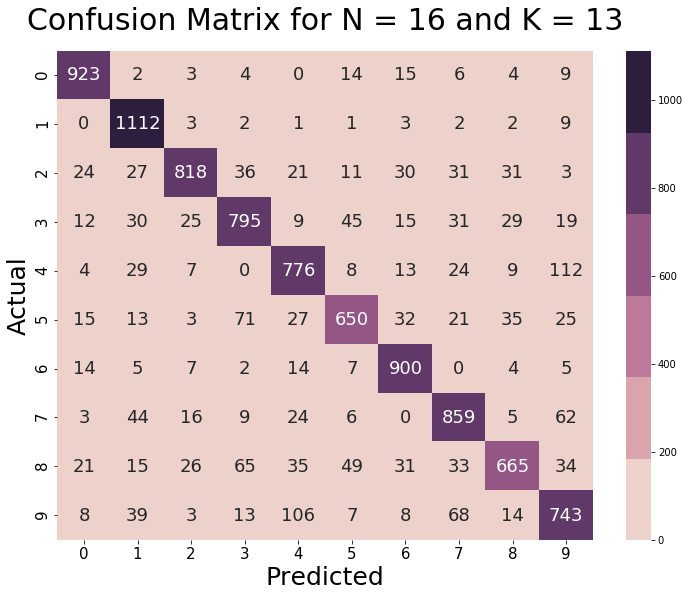

In [39]:
###########     N = 16    ###########
knn.confusion_matrix_plot(y_test, pred_ds16, "Confusion Matrix for N = 16 and K = " + str(best_k_ds16))

The interesting point about this model with N = 16 is that compared to previous two, it has almost struggled with all the digits except 1. This shows that identifying 1 is almost easy and can be done with few features compared to all other digits.

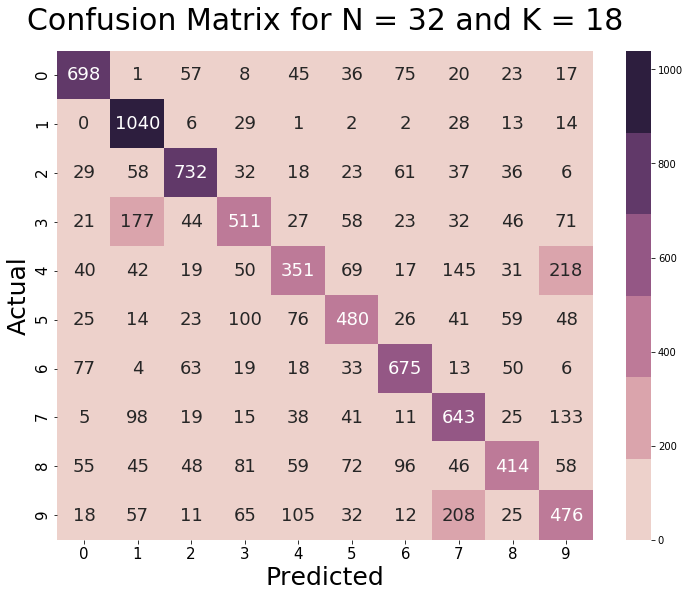

In [40]:
###########     N = 32    ###########
knn.confusion_matrix_plot(y_test, pred_ds32, "Confusion Matrix for N = 32 and K = " + str(best_k_ds32))

With almost 40% error rate, we can clearly see that N = 32 is struggling lot from the above confusion to make the prediction on test set. There is significantly huge errors happening in identifying 3 which is identified as 1. Similarly, 9 as 87 and 4 as 9.

### Testing error on each digit

Now lets see the testing error on each digits for each model and see whether there is something interesting out there for us. To make things easier I am going to make all the model results into a single table.

In [41]:
# Computing the testing error for each digits
###########     N = 4    ###########
result_ds4 = knn.testing_error(y_test, pred_ds4)
###########     N = 8    ###########
result_ds8 = knn.testing_error(y_test, pred_ds8)
###########     N = 16    ###########
result_ds16 = knn.testing_error(y_test, pred_ds16)
###########     N = 32    ###########
result_ds32 = knn.testing_error(y_test, pred_ds32)

# Creating a single Dataframe
result_ds4["Downsample (N)"] = [4 for i in range(len(result_ds4))]
result_ds8["Downsample (N)"] = [8 for i in range(len(result_ds8))]
result_ds16["Downsample (N)"] = [16 for i in range(len(result_ds16))]
result_ds32["Downsample (N)"] = [32 for i in range(len(result_ds32))]

# Combining into a single big list
lodf = [result_ds4, result_ds8, result_ds16, result_ds32]

# Creating and dispalying the dataframe
df = pd.concat([d.set_index('Downsample (N)') for d in lodf], axis=0).reset_index()
df

,Downsample (N),Accuracy (%),Error (%),Label
0,4,98.7755,1.2245,0
1,4,98.9427,1.0573,1
2,4,91.9574,8.0426,2
3,4,91.2871,8.7129,3
4,4,93.9919,6.0081,4
5,4,88.2287,11.7713,5
6,4,96.4509,3.5491,6
7,4,93.2879,6.7121,7
8,4,86.1396,13.8604,8
9,4,92.0714,7.9286,9


Thus the above table shows the error and accuracy percentage of each labels/digits for different downsample models with N = 4, 8, 16, 32. But this looks clumsy and we can easily derive insights out of it. So lets just use viusalization to see whether we have any insights in the above results.

In [42]:
# Creating the dataframe from the testing errors
plot_df = pd.DataFrame({'N = 4': result_ds4['Error (%)'], 'N = 8': result_ds8['Error (%)'], 
                       'N = 16': result_ds16['Error (%)'], 'N = 32': result_ds32['Error (%)']})

# Calling the custom line plot function
custom_analysis_multiline_plot(data = plot_df, title = "Testing Error on each digits with different N's",
                          width = 800, height = 600, xlab = "Image Label (digit)", ylab = "Testing Error (%)",
                          line_width = 4)

From the graph we can clearly infer the following insights

- The model with N = 4 has considerably better performance on each digits compared to other N values.
- The model with N = 32 is performing the worst for all the digits 
- There is some kind of a similar trend that could be identified on the error rate over the image labels from 0 to 9 for each values of N
- Incresing the N value decreases the model performance.

#### Thus overall from the down sampling question we can understand that 'n'th of downsample is inversly proportional to accuracy of the model and directly proportional to error of the model.

## Question 4

(20 pts) Implement a function that smart downsamples the image by binning nearby pixels. For example, if n is 4 then the 28x28 image will be binned down to a 7x7 image by summing each 4x4 block in the image. Repeat the KNN leave-one-out experiment with at least 4 different values of n. Comment on the testing results and the query time of the classifier.

For this question, I am taking the orignal image numpy array which is in shape (60000, 28, 28) --> (No of images, height, width) and than apply the n strides over it to get the output images of shape (60000, 7, 7). Let just do that first now. We need to do this for both the test and train images. 

I am going to apply downsamples for n = 2, 3, 4, 5 as four different values of strides for binning them together.

In [43]:
# Creating the Feature Transformation class object
knn = KNearestNeighbor()
transformation = FeatureTransformation()

# Calling the downsample() to do binning using summing
trainX_sds = transformation.down_sample(trainX, 2, binning = "sum")
testX_sds = transformation.down_sample(testX, 2, binning = "sum")

### Original Image

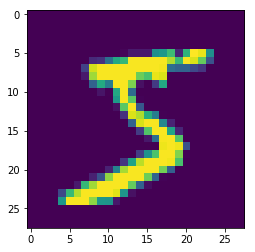

In [44]:
# Plot the image
plt.imshow(trainX[0])

### Aftrer Stride of 2

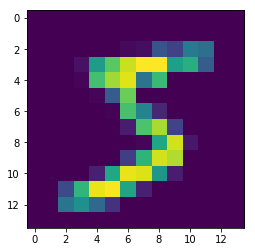

In [45]:
# Plot the image
plt.imshow(trainX_sds[0])

Above we have the two images showing how the image of the digit have changed after applying strides of 2. Lets reshape the train and test into a form that is suitable for the KNN computation ie) in 2D array format.

In [46]:
# Convert the shape of Train and Test set after strides application
X_train_sds = trainX_sds.reshape(trainX_sds.shape[0], trainX_sds.shape[1] * trainX_sds.shape[1])

# Print the changed shape
print(X_train_sds.shape)

(60000, 196)


Thus we have our image data converted into the form that is suitable for the KNN algorithm. Let try to fit the model. And for rest of the three different n values or strides, I have performed the same transformation and fitted the model with the corresponding data in the below code chunk.

In [47]:
###########     N = 2    ###########
# Store the starting time for query time computation
start_time = timeit.default_timer()

# Fit the model in the leave out CV method
knn.fit(X_train_sds, y_train, cv_k = 20, binning = "Sum")

# Print the Query time
time1 = round(timeit.default_timer() - start_time, 4)
print("Query time for N = 2:", time1, "second(s)")

# Get the needed terms in this stage
parameter_list_sds2 = knn.parameter_list
best_k_sds2 = knn.best_k
best_error_sds2 = knn.best_error


###########     N = 3    ###########
# Calling the downsample() to do binning using summing
trainX_sds = transformation.down_sample(trainX, 3, binning = "sum")
testX_sds = transformation.down_sample(testX, 3, binning = "sum")

# Convert the shape of Train and Test set after strides application
X_train_sds = trainX_sds.reshape(trainX_sds.shape[0], trainX_sds.shape[1] * trainX_sds.shape[1])

# Store the starting time for query time computation
start_time = timeit.default_timer()

# Fit the model in the leave out CV method
knn.fit(X_train_sds, y_train, cv_k = 20, binning = "Sum")

# Print the Query time
time2 = round(timeit.default_timer() - start_time, 4)
print("Query time for N = 3:", time2, "second(s)")

# Get the needed terms in this stage
parameter_list_sds3 = knn.parameter_list
best_k_sds3 = knn.best_k
best_error_sds3 = knn.best_error


###########     N = 4    ###########
# Calling the downsample() to do binning using summing
trainX_sds = transformation.down_sample(trainX, 4, binning = "sum")
testX_sds = transformation.down_sample(testX, 4, binning = "sum")

# Convert the shape of Train and Test set after strides application
X_train_sds = trainX_sds.reshape(trainX_sds.shape[0], trainX_sds.shape[1] * trainX_sds.shape[1])

# Store the starting time for query time computation
start_time = timeit.default_timer()

# Fit the model in the leave out CV method
knn.fit(X_train_sds, y_train, cv_k = 20, binning = "Sum")

# Print the Query time
time3 = round(timeit.default_timer() - start_time, 4)
print("Query time for N = 4:", time3, "second(s)")

# Get the needed terms in this stage
parameter_list_sds4 = knn.parameter_list
best_k_sds4 = knn.best_k
best_error_sds4 = knn.best_error


###########     N = 5    ###########
# Calling the downsample() to do binning using summing
trainX_sds = transformation.down_sample(trainX, 5, binning = "sum")
testX_sds = transformation.down_sample(testX, 5, binning = "sum")

# Convert the shape of Train and Test set after strides application
X_train_sds = trainX_sds.reshape(trainX_sds.shape[0], trainX_sds.shape[1] * trainX_sds.shape[1])

# Store the starting time for query time computation
start_time = timeit.default_timer()

# Fit the model in the leave out CV method
knn.fit(X_train_sds, y_train, cv_k = 20, binning = "Sum")

# Print the Query time
time4 = round(timeit.default_timer() - start_time, 4)
print("Query time for N = 5:", time4, "second(s)")

# Get the needed terms in this stage
parameter_list_sds5 = knn.parameter_list
best_k_sds5 = knn.best_k
best_error_sds5 = knn.best_error

Query time for N = 2: 48.4394 second(s)
Query time for N = 3: 57.2838 second(s)
Query time for N = 4: 57.7218 second(s)
Query time for N = 5: 59.669 second(s)


Above we have the computation time for each N values which is almost same for all the N values. The computation time is ~1 min as I am retriving the distance matrix from the file. It took ~28 mins of computation time for computing the distance matrix of (60000, 60000) size first time if the file is not in your system. When ever it is needed, the corresponding file will get loaded as directed by my implementation. One thing to note here is that my implementation took almost the same time to do Leave one out for all the four different N values. This is because I am computing the 60000 * 60000 sized matrix irrespective of what the N value is. 

### Choosing the best K

As we have our leave one out fit run for all 4 different smart down samples, lets do some analysis on the diffrent error values with respect to each K for those 4 smart downsample methods. We will use visualization to get this analysis going.

In [48]:
## Creating the dataframe for the Leave one out CV for each N different downsamples
errors_NK_df = pd.DataFrame({'K': [d['K'] for d in parameter_list_sds4],
             'N = 2': [d['Error'] for d in parameter_list_sds2], 
             'N = 3': [d['Error'] for d in parameter_list_sds3], 
             'N = 4':[d['Error'] for d in parameter_list_sds4], 
             'N = 5': [d['Error'] for d in parameter_list_sds5]})

# Calling the custom line plot function
custom_error_NK_plot(data = errors_NK_df.iloc[:, 1:], colour_range = [2, 6, 10, 14], title = "K vs Error for Smart downsamples (N)",
                    width = 800, height = 600, xlab = "No. of Neighbors (K)", ylab = "Error (%)", 
                     line_width = 4)

From the graph we can see that the N = 2 that is 2 * 2 strides with 3 Neighbors (K = 3) is having the lowest error percentage overall. We can also see that the trend between different N smart downsamples is almost the same from the graph. And also it is so clear that Error increases as we increase N value for our smart downsample.

Below we have best error and most importantly best K value for each of the smart downsample fit we did.

| Smart Downsample (N) | Best Error |  Best K  |
|--------------|------------|----------|
|   2   |  2.1867   | <strong>3</strong> |
|   3   |  2.6533   |  <strong>3</strong> |
|   4   |  4.245   |  <strong>4</strong> |
|   5   |  8.655   |  <strong>5</strong> |

### Prediction on the test set

With the process of choosing our best model, we have got to know what are the best K values that work for each smart downsample feature which we have applied over. Thus lets use those best k values from the leave one out cross validation fit and apply on the test set to make the prediction.

In [49]:
###########     N = 2    ###########
# Make the transformation
trainX_sds = transformation.down_sample(trainX, 2, binning = "sum")
knn.X = trainX_sds.reshape(trainX_sds.shape[0], trainX_sds.shape[1] * trainX_sds.shape[1])
testX_sds = transformation.down_sample(testX, 2, binning = "sum")
X_test_sds = testX_sds.reshape(testX_sds.shape[0], testX_sds.shape[1] * testX_sds.shape[1])
# Store the starting time for query time computation
start_time = timeit.default_timer()

# Make prediction on the test set
pred_sds2 = knn.predict(X_test_sds, k = best_k_sds2, binning = "Sum")

# Print the Query time
time1 = round(timeit.default_timer() - start_time, 4)
print("Query time for N = 2:", time1, "second(s)")


# ###########     N = 3    ###########
# Make the transformation
trainX_sds = transformation.down_sample(trainX, 3, binning = "sum")
knn.X = trainX_sds.reshape(trainX_sds.shape[0], trainX_sds.shape[1] * trainX_sds.shape[1])
testX_sds = transformation.down_sample(testX, 3, binning = "sum")
X_test_sds = testX_sds.reshape(testX_sds.shape[0], testX_sds.shape[1] * testX_sds.shape[1])

# Store the starting time for query time computation
start_time = timeit.default_timer()

# Make prediction on the test set
pred_sds3 = knn.predict(X_test_sds, k = best_k_sds3, binning = "Sum")

# Print the Query time
time2 = round(timeit.default_timer() - start_time, 4)
print("Query time for N = 3:", time2, "second(s)")


###########     N = 4    ###########
# Make the transformation
trainX_sds = transformation.down_sample(trainX, 4, binning = "sum")
knn.X = trainX_sds.reshape(trainX_sds.shape[0], trainX_sds.shape[1] * trainX_sds.shape[1])
testX_sds = transformation.down_sample(testX, 4, binning = "sum")
X_test_sds = testX_sds.reshape(testX_sds.shape[0], testX_sds.shape[1] * testX_sds.shape[1])

# Store the starting time for query time computation
start_time = timeit.default_timer()

# Make prediction on the test set
pred_sds4 = knn.predict(X_test_sds, k = best_k_sds4, binning = "Sum")

# Print the Query time
time3 = round(timeit.default_timer() - start_time, 4)
print("Query time for N = 4:", time3, "second(s)")

###########     N = 5    ###########
# Make the transformation
trainX_sds = transformation.down_sample(trainX, 5, binning = "sum")
knn.X = trainX_sds.reshape(trainX_sds.shape[0], trainX_sds.shape[1] * trainX_sds.shape[1])
testX_sds = transformation.down_sample(testX, 5, binning = "sum")
X_test_sds = testX_sds.reshape(testX_sds.shape[0], testX_sds.shape[1] * testX_sds.shape[1])

# Store the starting time for query time computation
start_time = timeit.default_timer()

# Make prediction on the test set
pred_sds5 = knn.predict(X_test_sds, k = best_k_sds5, binning = "Sum")

# Print the Query time
time4 = round(timeit.default_timer() - start_time, 4)
print("Query time for N = 4:", time4, "second(s)")

Query time for N = 2: 8.2999 second(s)
Query time for N = 3: 4.1629 second(s)
Query time for N = 4: 5.126 second(s)
Query time for N = 4: 4.2789 second(s)


So we have made the prediction on the test set for each of the N's in our smart downsamples. Looking at the query time it is too small and almost all of the prediction took around ~5 to 8 seconds mark. This is because of the similarity matrix computation which is already being done at first time execution. This similarity matrix of size 10000 * 10000 computation took about ~60 seconds for all the 4 different downsamples. We just load this matrix from the file and use those as a look up tables and make our prediction. That is the reason we have small prediction time here which is good. 

Moving further are their any trend prevaling with the time.

### Prediction Query time plot for N downsamples

In [50]:
# Show the plot
time = pd.DataFrame({'Downsamples N': [4, 8, 16, 32], 
                     'Query Time': [time1, time2, time3, time4]})
custom_analysis_line_plot(data = time, x_col = 0, y_col = 1, title = "Downsamples (N) Vs Query Time", 
                     width = 800, height = 600, xlab = "Downsamples", ylab = "Query Time", line_width = 4)

Most of the time when I was seeing the output it was around 5 seconds for all the models to make predictions. One thing to notice is that the ups and downs that have shown in the graph prevails at all the execctuion irrespective of their scale.

### Accuracy and Error percentage

Though we have predicted the test set. We need to know how good is the model by measuring some metrics. I am going to find the accuracy and error rate of each smart downsampled models to see how well it have performed on the test set.

In [51]:
# Creating the error list to make plot
error_list = []
###########     N = 2    ###########
# Call the accuracy to get the accuracy
acc = knn.accuracy(y_test, pred_sds2)
# Calculate the error from accuracy
err = 100 - acc
# Add to the error list
error_list.append(err)
# Print both accuracy and error
print("N = 2")
print("The accuracy rate of the model is", acc, "percentage.")
print("The error rate of the model is", err, "percentage.")
print("\n")


###########     N = 3    ###########
# Call the accuracy to get the accuracy
acc = knn.accuracy(y_test, pred_sds3)
# Calculate the error from accuracy
err = 100 - acc
# Add to the error list
error_list.append(err)
# Print both accuracy and error
print("N = 3")
print("The accuracy rate of the model is", acc, "percentage.")
print("The error rate of the model is", err, "percentage.")
print("\n")


###########     N = 4    ###########
# Call the accuracy to get the accuracy
acc = knn.accuracy(y_test, pred_sds4)
# Calculate the error from accuracy
err = 100 - acc
# Add to the error list
error_list.append(err)
# Print both accuracy and error
print("N = 4")
print("The accuracy rate of the model is", acc, "percentage.")
print("The error rate of the model is", err, "percentage.")
print("\n")


###########     N = 5    ###########
# Call the accuracy to get the accuracy
acc = knn.accuracy(y_test, pred_sds5)
# Calculate the error from accuracy
err = 100 - acc
# Add to the error list
error_list.append(err)
# Print both accuracy and error
print("N = 5")
print("The accuracy rate of the model is", acc, "percentage.")
print("The error rate of the model is", err, "percentage.")
print("\n")

N = 2
The accuracy rate of the model is 97.31 percentage.
The error rate of the model is 2.69 percentage.


N = 3
The accuracy rate of the model is 96.81 percentage.
The error rate of the model is 3.19 percentage.


N = 4
The accuracy rate of the model is 95.31 percentage.
The error rate of the model is 4.69 percentage.


N = 5
The accuracy rate of the model is 90.59 percentage.
The error rate of the model is 9.41 percentage.




In [52]:
# Create the dataframe
error_rate_df = pd.DataFrame({'Downsamples N': [2, 3, 4, 5], 
                             'Error': error_list})

# Show the plot
custom_analysis_line_plot(data = error_rate_df, x_col = 0, y_col = 1, title = "Smart Downsamples (N) vs Error %", 
                         width = 800, height = 600, xlab = "Smart Downsamples (N)", ylab = "Testing Error (%)", 
                          line_width = 4)

From the above printed result and also from the visualization we can clearly see that the error rate increases as increase our N (N * N strides) in the downsamples selection. This is because big the N value less the number of features you are going to have for your model which makes sense.

### Confusion matrix

Confusion Matrix help us understand the model performance by provinding insights on how well the model performed on each digits, and where it is strugling to make the prediction. Let see how our four different KNN model with smart downsamples has performed with their each best K value.

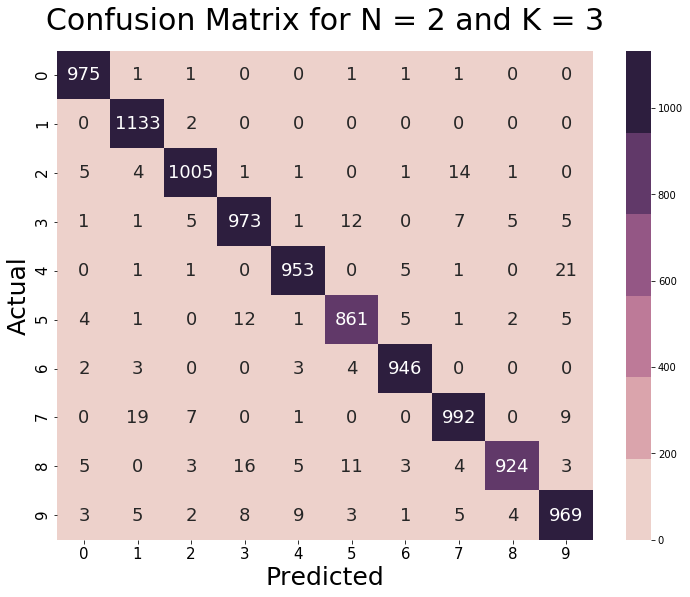

In [53]:
# Create and show the Confusion matrix plot
###########     N = 2    ###########
knn.confusion_matrix_plot(y_test, pred_sds2, "Confusion Matrix for N = 2 and K = " + str(best_k_sds2))

With the accuracy of 97.13%, the above confusion matrix clearly shows the insights what it said to be a good model. The small drop in the accuracy os due to the missclassification in predicting the image 5 and 8 on comparision with our model that is in the question 2.

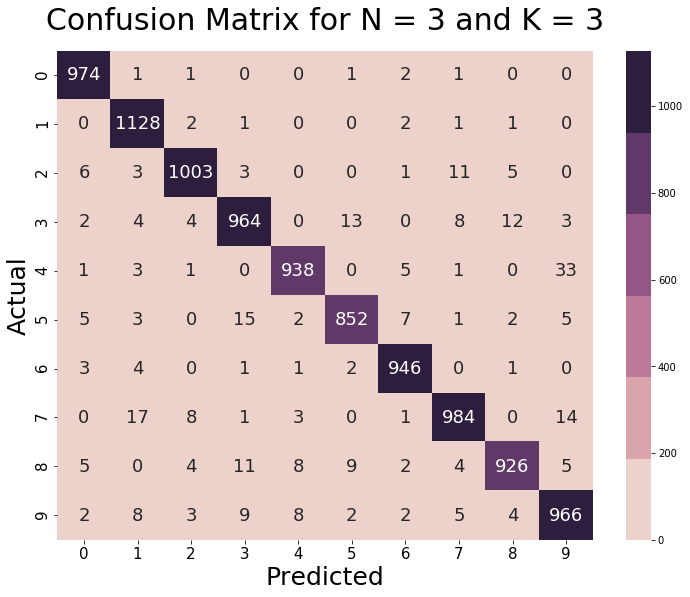

In [54]:
###########     N = 3    ###########
knn.confusion_matrix_plot(y_test, pred_sds3, "Confusion Matrix for N = 3 and K = " + str(best_k_sds3))

This confusion matrix for the model with N = 3 ie) 3 * 3 and best K value as 5 is much similar to that of the previous confusion matrix with N = 2. Although they are similar, in addition to missclassification we saw with images of 5 and 8 with the previous confusion matrix. we have missclassifcation in 4 to certain extent.

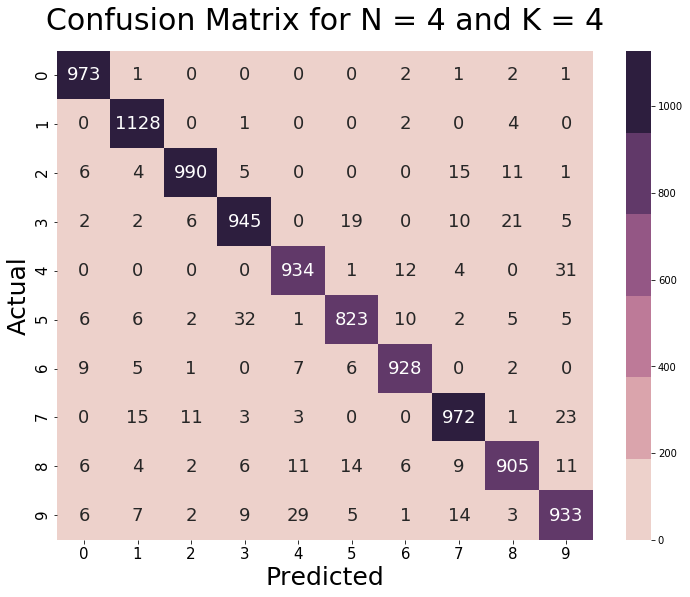

In [55]:
###########     N = 4    ###########
knn.confusion_matrix_plot(y_test, pred_sds4, "Confusion Matrix for N = 4 and K = " + str(best_k_sds4))

Here we can see that we are getting shading out on the diagonals which is due to decrease in the accuracy of the model. In addition to missclassification in the previous confusion matrix is that there is slight decrease in number of images that are identified as 9.

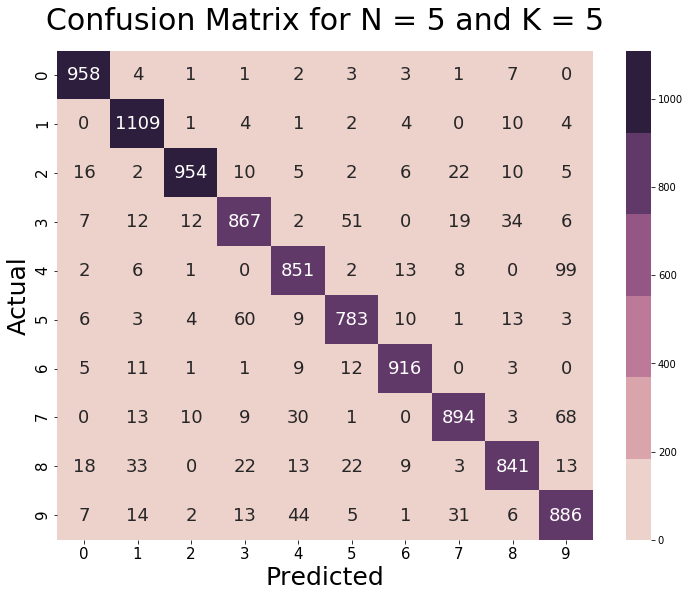

In [56]:
###########     N = 5    ###########
knn.confusion_matrix_plot(y_test, pred_sds5, "Confusion Matrix for N = 5 and K = " + str(best_k_sds5))

With the strides of 5 * 5, we see increase in the missclassification error of the images/digits from 3 to 9. One thing most important to see is that in all the strides we have seen so far, digits 0 to 2 gets almost identifed in all the models compared to other digits.

### Testing error on each digit

Now lets see the testing error on each digits for each of our smart downsample models and see whether there is something interesting out there for us. To make things easier I am going to make all the model results into a single table.

In [57]:
# Computing the testing error for each digits
###########     N = 2    ###########
result_sds2 = knn.testing_error(y_test, pred_sds2)
###########     N = 3    ###########
result_sds3 = knn.testing_error(y_test, pred_sds3)
###########     N = 4    ###########
result_sds4 = knn.testing_error(y_test, pred_sds4)
###########     N = 5    ###########
result_sds5 = knn.testing_error(y_test, pred_sds5)

# Creating a single Dataframe
result_sds2["Smart Downsample (N)"] = [2 for i in range(len(result_sds2))]
result_sds3["Smart Downsample (N)"] = [3 for i in range(len(result_sds3))]
result_sds4["Smart Downsample (N)"] = [4 for i in range(len(result_sds4))]
result_sds5["Smart Downsample (N)"] = [5 for i in range(len(result_sds5))]

# Combining into a single big list
lodf = [result_sds2, result_sds3, result_sds4, result_sds5]

# Creating and dispalying the dataframe
df = pd.concat([d.set_index('Smart Downsample (N)') for d in lodf], axis=0).reset_index()
df

,Smart Downsample (N),Accuracy (%),Error (%),Label
0,2,99.4898,0.5102,0
1,2,99.8238,0.1762,1
2,2,97.3837,2.6163,2
3,2,96.3366,3.6634,3
4,2,97.0468,2.9532,4
5,2,96.5247,3.4753,5
6,2,98.7474,1.2526,6
7,2,96.4981,3.5019,7
8,2,94.8665,5.1335,8
9,2,96.0357,3.9643,9


Thus the above table shows the error and accuracy percentage of each labels/digits for different smart downsample models with N = 2, 3, 4, 5. But this looks clumsy and we can easily derive insights out of it. So lets just use viusalization to see whether we have any insights in the above results.

In [58]:
# Creating the dataframe from the testing errors
plot_df = pd.DataFrame({'N = 2': result_sds2['Error (%)'], 'N = 3': result_sds3['Error (%)'], 
                       'N = 4': result_sds4['Error (%)'], 'N = 5': result_sds5['Error (%)']})

# Calling the custom line plot function
custom_analysis_multiline_plot(data = plot_df, title = "Testing Error on each digits with different N's",
                          width = 800, height = 600, xlab = "Image Label (digit)", ylab = "Testing Error (%)",
                          line_width = 4)

From the graph we can clearly infer the following insights

- The model with N = 2 (2 * 2 strides) has considerably better performance on each digits except 8 compared to other N smart downsamples values
- The model with N = 5 (5 * 5 strides) is performing the worst for all the digits compared to other models
- There is some kind of a similar trend that could be identified on the error rate over the image labels from 0 to 9 for each N values
- Incresing the N value decreases the model performance.

#### Thus overall from the down sampling question we can understand that 'nth' of downsample is inversly proportional to accuracy of the model and directly proportional to error of the model.

## Question 5

(10 pts) Run your smart downsampler at n = 28. Essentially, reduce each image down to 1 pixel by summing them all. The motivation here is that an '8' will obviously have more dark pixels than a '1' . Repeat the KNN leave-one-out experiment. Comment on the testing results and the query time of the classifier

So this question is similar to that of the previous qiestion where as instead of choosing the N value on our own, we need to use N = 28. Actually what we are doing is that just reducing the whole image into one single pixel by summming it and using that one single feature to make the prediction.

In [59]:
# Creating the Feature Transformation class object
knn = KNearestNeighbor()
transformation = FeatureTransformation()

# Calling the downsample() to do binning using summing
trainX_sds = transformation.down_sample(trainX, 28, binning = "sum")
testX_sds = transformation.down_sample(testX, 28, binning = "sum")

Let just view the original and image after feature transformation.

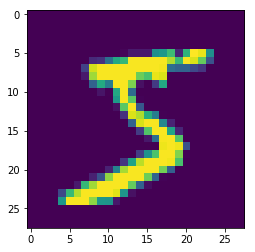

In [60]:
# Original Image
plt.imshow(trainX[0])

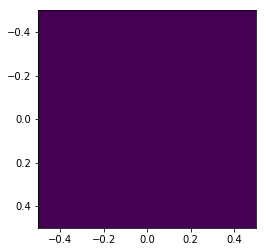

In [61]:
# After transformation
plt.imshow(trainX_sds[0])

As we could see here that a image is jusr a representation of just a single pixel. Thus our feature vector is just going to be single vector of 60000 rows. Let just do that by reshaping the train image that is suitable for the KNN computation ie) in 2D array format.

In [62]:
# Convert the shape of Train and Test set after strides application
X_train_sds = trainX_sds.reshape(trainX_sds.shape[0], trainX_sds.shape[1] * trainX_sds.shape[1])

# Print the changed shape
print(X_train_sds.shape)

(60000, 1)


Thus we have our image data converted into the form (60000 * 1 matrix) that is suitable for the KNN algorithm. Let try to fit the model. 

In [63]:
# Store the starting time for query time computation
start_time = timeit.default_timer()

# Fit the model in the leave out CV method
knn.fit(X_train_sds, y_train, cv_k = 20, binning = "Sum")

# Print the Query time
time1 = round(timeit.default_timer() - start_time, 4)
print("Query time:", time1, "second(s)")

# Get the needed terms in this stage
parameter_list = knn.parameter_list
best_k = knn.best_k
best_error = knn.best_error

Query time: 50.6667 second(s)


Apparently the computation for creating the whole distance matrix and then finding the K nearest neighbour for 20 k's caused about 25 mins. However, I have saved the sorted version of the whole big distance matrix into a numpy formatted file so that when ever if the values are required it can be returned from the file and computation time can be hugely reduced.

By following the above approach I have reduced the execution time from 25 mins to ~51 seconds. Here the distance matrix is loaded from the file. However if the distance matrix is already in the class object instance then it will be super fast with a query time ~0.7 seconds. With that being done we have our best k value and errors from the 20 iteration we did above. Lets look at that first.

### Choosing the best K

In my code above in the fit function I have already computed the best k value and its error. However, in order to understand things intutively, lets plot the k vs error rate.

In [64]:
# Prepare the require data and show the plot
parameter_list_df = pd.DataFrame(knn.parameter_list)
custom_analysis_line_plot(data = parameter_list_df, x_col = 1, y_col = 0, title = "K vs Error %", 
                     width = 800, height = 600, xlab = "No. Neighbors (K)", ylab = "Error (%)", line_width = 4)

From the graph it is evident and clear that we have very low error rate for K = 1 which is 60.54. And keeps increasing as we increase our K values. Let just confirm the number by looking at the best k value and its error rate from the corresponding variable in the class object.

In [65]:
print("The best K value for this dataset according to leave one out cross validation is", knn.best_k,
     "and the correponding error rate is", knn.best_error)

The best K value for this dataset according to leave one out cross validation is 1 and the correponding error rate is 60.54


Thus above we can see that my inference from the graph is true. The best K value is 1. Lets use the best K value which is 1 to predict the images in the test set.

### Predicting on test set with K = 1

As we have the class object and fitted our model with leave one cross validation, we have figured out that K = 1 will be the best model to use to make the prediction on new the test images with one features. Lets try to predict the images in the testing set of images with one feature using predict() in KNearestNeighbor class with K as 1.

In [66]:
# Convert the shape of Train and Test set after strides application
X_test_sds = testX_sds.reshape(testX_sds.shape[0], testX_sds.shape[1] * testX_sds.shape[1])

# Store the starting time for query time computation
start_time = timeit.default_timer()

# Make prediction on the test set
pred = knn.predict(X_test_sds, k = knn.best_k, binning = "Sum")

# Print the Query time
print("Query time:", round(timeit.default_timer() - start_time, 4), "Seconds")

Query time: 2.5234 Seconds


Thus we have made our prediction on the test set with k = 1. When looking at the Query time, it took ~6 seconds to do the computation if it has to load the distance matrix from the file. If the distance matirx is not found then the time it will take is to compute is ~72 seconds.

If we already have the correct distance matrix in the class object then computation time will be ~40 miliseconds which is super fast.

We just load this matrix from the file and use those as a look up tables and make our prediction. That is the reason we have small prediction time here which is good.

### Accuracy and error rate

Though we have predicted the test set. We need to know how good is the model with one feature for each images is performing by measuring some metrics. I am going to find the accuracy and error rate of the model to see how well it have performed on the test set.

In [67]:
# Call the accuracy to get the accuracy
acc = knn.accuracy(y_test, pred)
# Calculate the error from accuracy
err = 100 - acc
# Print both accuracy and error
print("The accuracy rate of the model is", acc, "percentage.")
print("The error rate of the model is", err, "percentage.")

The accuracy rate of the model is 16.14 percentage.
The error rate of the model is 83.86 percentage.


The KNN model with just one feature vector has the accuracy of 16.14% with K = 1 which is very low. Let just use confusion matrix to see what and where this model is going wrong.

### Confusion Matrix

Confusion Matrix help us understand the model performance by provinding insights on how well the model performed on each digits, and where it is strugling to make the prediction. Let see how our KNN model with K = 1 has performed.

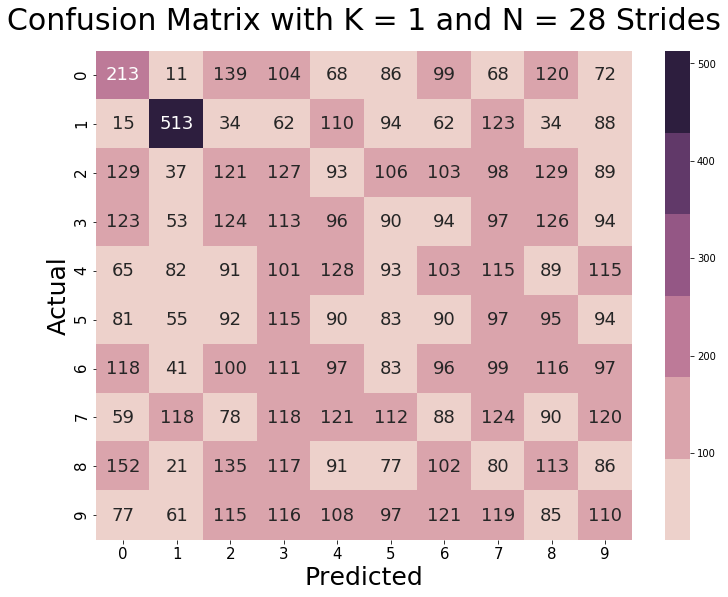

In [68]:
# Create and show the Confusion matrix plot
knn.confusion_matrix_plot(y_test, pred, "Confusion Matrix with K = 1 and N = 28 Strides")

There is not much to say from this confusion matrix. The error rate being almost 87%, the prediction the model made are all over the places. However it was able to predict image 1 comparatively better to other images.

### Testing error on each digit

Now lets see the testing error on each digits for this model and see whether there is something interesting out there for us.

In [69]:
# Computing the testing error for each digits
result_KNNCV = knn.testing_error(y_test, pred)

# Printing the testing error table
result_KNNCV

,Accuracy (%),Error (%),Label
0,21.7347,78.2653,0
1,45.1982,54.8018,1
2,11.7248,88.2752,2
3,11.1881,88.8119,3
4,13.0346,86.9654,4
5,9.3049,90.6951,5
6,10.0209,89.9791,6
7,12.0623,87.9377,7
8,11.6016,88.3984,8
9,10.9019,89.0981,9


In [70]:
# Prepare the require data and show the plot
error_df = pd.DataFrame({'Labels': [0, 1, 2, 3, 4, 5, 6 ,7 ,8 ,9],
                     'Error': result_KNNCV["Error (%)"]})
custom_analysis_line_plot(data = error_df, x_col = 1, y_col = 0, title = "Testing Error for each digits", 
                     width = 800, height = 600, xlab = "Label/Image", ylab = "Testing Error (%)", line_width = 4)

Above we have the table that shows testing error and also accuracy rate for each digit on the test set for the KNN model with just one feature and K = 1. We can see that

- Image 1 has low error rate
- Image 2 to 9 has very high error rates
- Over all this model having average error rate of 86 is not considered to be a good model.

## Question 6

(30 pts) Do a little research of your own and develop a feature transformation method that you then use with the KNN leave-one-out experiment. Describe your method in detail, using equations and figures as necessary. Someone should be able to reproduce your results with your description. Comment on the testing results and the query time of the classifier.

### Solution

MNIST is a bunch of images to which are used to create a Handwritten recongition model for USPS to identify zipcodes in the letters. It was carried out by one of the pioneering researcher in the field of Deep Learning, Dr. Yann Le Cun. DR. LeCun is widely known for his inventions and cutting edge research in the field of Convolution Neural Networks which is technique overall driving force for solving the Image recognition problem. 

So I decided to use one of the techniques which is used in the architechture of Convolution Neural Networks (CNN) called pooling. Its function is to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network, and hence to also control overfitting. The pooling methodology can be classified in two different ways. They are

- Max Pooling
- Min Pooling

But it is generally believed that by most of the researchers and by engineers in big firm that Max Pooling is by far better than Min and Sum Pooling because the values of the neighbourhood cells are not independent when the feature is present in the neighbourhood. As a result, linear summation makes no sense. <strong>And thus I am going to implement Max Pooling feature transformation for this question.</strong> Before heading on to the KNN, lets spend some time in learning what is Max Pooling in bit detail.

### Max Pooling

Max pooling is a sample-based discretization process. The objective is to down-sample an input representation (image, hidden-layer output matrix, etc.), reducing its dimensionality and allowing for assumptions to be made about features contained in the sub-regions binned.

This is done to in part to help over-fitting by providing an abstracted form of the representation. As well, it reduces the computational cost by reducing the number of parameters to learn and provides basic translation invariance to the internal representation.

Max pooling is done by applying a max filter to (usually) non-overlapping subregions of the initial representation.

Let's say we have a 4x4 matrix representing our initial input. 

Let's say, as well, that we have a 2x2 filter that we'll run over our input. We'll have a stride of 2 (meaning the (dx, dy) for stepping over our input will be (2, 2)) and won't overlap regions.

For each of the regions represented by the filter, we will take the max of that region and create a new, output matrix where each element is the max of a region in the original input.

In order to make this super easy, with a nice pictorial representation - I give you this:

<img src="https://raw.githubusercontent.com/nishanthgandhidoss/nishanthgandhidoss.github.io/master/image/Max_pooling.png" height="800px" width="600px" align="center" alt="Max Pooling"/>

The use of max pooling can be justified using simple intuition. Say a city has 4 districts. When someone asks you if the city is raining, and you have the data of whether each of the 4 districts is raining, what do you do? If any of the 4 districts is raining, you say yes. This is max pooling. You don't count the number of districts that are raining and then divide it by 4. The above is a very crude analogy. There is a better one, but it requires a bit of insight: a feature (of the right size) usually does not appear twice in a small neighbourhood. 

When it does, the input image would be somewhat blurry or perhaps "ghostly". Say we have a neighbourhood of 4 cells, on which we perform pooling. If a feature is detected at the first cell, then it is less likely to be detected in the other 3 cells. If all that we are concerned with is whether the feature is present within this small neighbourhood, taking the average from the 4 cells would cause the output value to be lower than the actual value. 

### I am going to use this Max Pooling techniques on the image with strides of 2 * 2 and perform the procedure which I followed in the previous question to see what sort of outputs I am getting for this. Lets do it!

In [71]:
# Creating the Feature Transformation class object
knn = KNearestNeighbor()
transformation = FeatureTransformation()

# Calling the downsample() to do binning using summing
trainX_mp = transformation.down_sample(trainX, 2, binning = "max")
testX_mp = transformation.down_sample(testX, 2, binning = "max")

In [72]:
trainX_mp.shape

(60000, 14, 14)

Let just view the original and image after feature transformation.

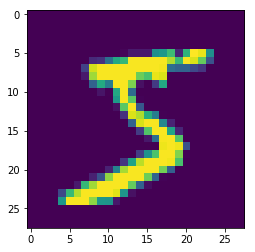

In [73]:
# Original Image
plt.imshow(trainX[0])

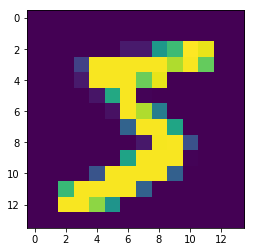

In [74]:
# After transformation
plt.imshow(trainX_mp[0])

We can see that the max pooling has kind of shaded the image which will help in the learning procedure. Let just do that by reshaping the train image that is suitable for the KNN computation ie) in 2D array format.

In [75]:
# Convert the shape of Train and Test set after strides application
X_train_mp = trainX_mp.reshape(trainX_mp.shape[0], trainX_mp.shape[1] * trainX_mp.shape[1])

# Print the changed shape
print(X_train_mp.shape)

(60000, 196)


Thus we have our image data converted into the form (60000, 196) matrix that is suitable for the KNN algorithm. Let try to fit the model.

In [76]:
# Store the starting time for query time computation
start_time = timeit.default_timer()

# Fit the model in the leave out CV method
knn.fit(X_train_mp, y_train, cv_k = 20, binning = "Max")

# Print the Query time
time = round(timeit.default_timer() - start_time, 4)
print("Query time:", time, "second(s)")

# Get the needed terms in this stage
parameter_list = knn.parameter_list
best_k = knn.best_k
best_error = knn.best_error

Query time: 49.8567 second(s)


Apparently the computation for creating the whole distance matrix and then finding the K nearest neighbour for 20 k's caused about ~25 mins. However, I have saved the sorted version of the whole big distance matrix into a numpy formatted file so that when ever if the values are required it can be returned from the file and computation time can be hugely reduced.

By following the above approach I have reduced the execution time from 25 mins to ~1 minute. Here the distance matrix is loaded from the file. However if the distance matrix is already in the class object instance then it will be super fast with a query time ~0.7 seconds. With that being done we have our best k value and errors from the 20 iteration we did above. Lets look at that first.

### Choosing the best K

In my code above in the fit function I have already computed the best k value and its error. However, in order to understand things intutively, lets plot the k vs error rate.

In [77]:
# Prepare the require data and show the plot
parameter_list_df = pd.DataFrame(knn.parameter_list)
custom_analysis_line_plot(data = parameter_list_df, x_col = 1, y_col = 0, title = "K vs Error %", 
                     width = 800, height = 600, xlab = "No. Neighbors (K)", ylab = "Error (%)", line_width = 4)

From the graph it is evident and clear that we have very low error rate for K = 0 which is 2.8633. The trend is like it starts with low error rate at K =1 and rises for K = 2. But the best K value of 3 comes up with the decrease in the error rate which is good. From there on it is on incresing trend. Let just confirm the number by looking at the best k value and its error rate from the corresponding variable in the class object

In [78]:
print("The best K value for this dataset according to leave one out cross validation is", knn.best_k,
     "and the correponding error rate is", knn.best_error)

The best K value for this dataset according to leave one out cross validation is 3 and the correponding error rate is 2.8633


Thus above we can see that my inference from the graph is true. The best K value is 3. Lets use the best K value which is 3 to predict the images in the test set.

### Predicting on test set with K = 3

As we have the class object and fitted our model with leave one cross validation, we have figured out that K = 3 will be the best model to use to make the prediction on new the test images with one features. Lets try to predict the images in the testing set of images with our max pooled feature using predict() in KNearestNeighbor class with K as 3.

In [79]:
# Convert the shape of Train and Test set after strides application
X_test_mp = testX_mp.reshape(testX_mp.shape[0], testX_mp.shape[1] * testX_mp.shape[1])

# Store the starting time for query time computation
start_time = timeit.default_timer()

# Make prediction on the test set
pred = knn.predict(X_test_mp, k = knn.best_k, binning = "Max")

# Print the Query time
print("Query time:", round(timeit.default_timer() - start_time, 4), "Seconds")

Query time: 2.2496 Seconds


Thus we have made our prediction on the test set with k = 3. When looking at the Query time, it took ~3 seconds to do the computation if it has to load the distance matrix from the file. If the distance matirx is not found then the time it will take is to compute is ~72 seconds.

If we already have the correct distance matrix in the class object then computation time will be ~40 miliseconds which is super fast.

We just load this matrix from the file and use those as a look up tables and make our prediction. That is the reason we have small prediction time here which is good.

### Accuracy and error rate

Though we have predicted the test set. We need to know how good is the model with one feature for each images is performing by measuring some metrics. I am going to find the accuracy and error rate of the model to see how well it have performed on the test set.m

In [80]:
# Call the accuracy to get the accuracy
acc = knn.accuracy(y_test, pred)
# Calculate the error from accuracy
err = 100 - acc
# Print both accuracy and error
print("The accuracy rate of the model is", acc, "percentage.")
print("The error rate of the model is", err, "percentage.")

The accuracy rate of the model is 96.66 percentage.
The error rate of the model is 3.34 percentage.


The KNN model with Max pooling of strides of 2*2 feature vector has the accuracy of 96.66% with K = 1 which is good. Let just use confusion matrix to see what the model got to gives as insights.

### Confusion Matrix

Confusion Matrix help us understand the model performance by provinding insights on how well the model performed on each digits, and where it is strugling to make the prediction. Let see how our KNN model with K = 1 has performed.

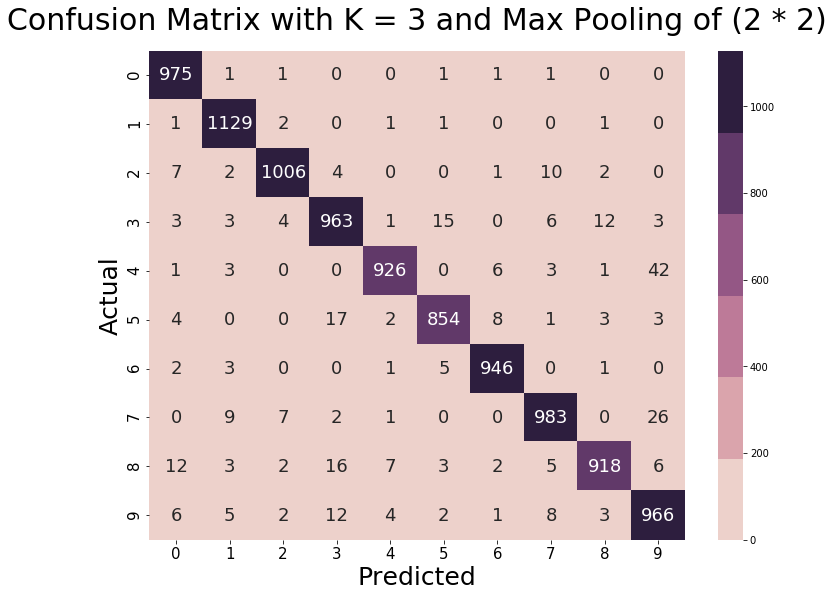

In [81]:
# Create and show the Confusion matrix plot
knn.confusion_matrix_plot(y_test, pred, "Confusion Matrix with K = 3 and Max Pooling of (2 * 2)")

From the confusion matrix of Max pooling, I was able to infer lot of insights which are as follows.

- The darker diagonals on the confusion matrix indicates we have good model that was able to predict the digits properly
- It looks like approximately digits 1 has more likely chances to be right. However this can be clearly stated once we get to our testing error table.
- Model is slightly failing behind with the images of 4, 5, 8

Overall the missclassification that have happened kind of make sense looking at the digits and its writing structure. Lets also see the testing error table for each digits.

### Testing error on each digit

Now lets see the testing error on each digits and see whether there is something interesting out there for us.

In [82]:
# Computing the testing error for each digits
result_KNNCV = knn.testing_error(y_test, pred)

# Printing the testing error table
result_KNNCV

,Accuracy (%),Error (%),Label
0,99.4898,0.5102,0
1,99.4714,0.5286,1
2,97.4806,2.5194,2
3,95.3465,4.6535,3
4,94.2974,5.7026,4
5,95.7399,4.2601,5
6,98.7474,1.2526,6
7,95.6226,4.3774,7
8,94.2505,5.7495,8
9,95.7384,4.2616,9


In [83]:
# Prepare the require data and show the plot
error_df = pd.DataFrame({'Labels': [0, 1, 2, 3, 4, 5, 6 ,7 ,8 ,9],
                     'Error': result_KNNCV["Error (%)"]})
custom_analysis_line_plot(data = error_df, x_col = 1, y_col = 0, title = "Testing Error for each digits", 
                     width = 800, height = 600, xlab = "Label/Image", ylab = "Testing Error (%)", line_width = 4)

The above table and graph clearly shows the following insights about our KNN model with max pooling of strides of (2, 2)

- Images of 0 and 1 are identified better than other digits with the error rate of less than 0.2 which is really good
- Images of 4 and 8 are having high error rate that are almost nearing 6 percent
- Increase in error rate happened from 1 to 4 and 6 to 8 is kind of looking like a similar trend

Overall this model with Max pooling is kind of good with a overall average accuracy of almost 97%. KNN with combination of Max Pooling feature transformation looks a good performing model. 

## End of assignment